In [219]:

import os, sys
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import joblib
from scipy import stats
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import warnings

path_to_file= r"vietnam_housing_dataset (1).csv"
vietnam_housing = pd.read_csv(r"vietnam_housing_dataset (1).csv")
vietnam_housing = vietnam_housing[['Address',	'Area',	'Frontage','Access Road',  'House direction',	'Balcony direction', 	'Floors',	'Bedrooms',	'Bathrooms',	'Legal status',	'Furniture state',	'Price']]

## Chia dữ liệu


In [220]:
from sklearn.model_selection import train_test_split
seed = 42
index_all = np.arange(vietnam_housing.shape[0])
index_train, index_test = train_test_split(index_all, test_size=0.33, random_state=seed)

In [221]:
vietnam_housing_train = vietnam_housing.iloc[index_train]
vietnam_housing_test  = vietnam_housing.iloc[index_test]
print(f"train: {len(vietnam_housing_train)} / test: {len(vietnam_housing_test)} - Tỷ lệ: {len(vietnam_housing_train) / len(vietnam_housing):.3f}, {len(vietnam_housing_test) / len(vietnam_housing):.3f}")

train: 1772 / test: 874 - Tỷ lệ: 0.670, 0.330


In [222]:

# Lưu dữ liệu sau khi chia
import os
from pathlib import Path
# define experiment directory (change if you prefer another path)
exps_dir = Path("./exps")
(exps_dir / "data").mkdir(parents=True, exist_ok=True)
vietnam_housing_train.to_excel(f'{exps_dir}/data/train.xlsx', index=None)
vietnam_housing_test.to_excel(f'{exps_dir}/data/test.xlsx', index=None)
np.savez(f'{exps_dir}/data/idx.npz', id_train = index_train, id_test = index_test)


In [223]:
pd.read_excel(f'{exps_dir}/data/train.xlsx')

Address   Area  Frontage  \
0     2174, Đường Huỳnh Tấn Phát, Xã Phú Xuân, Nhà B...   22.4       4.0   
1           Đường 21B, Phường Đồng Mai, Hà Đông, Hà Nội   34.0       3.5   
2       Phố Cầu Cốc, Phường Tây Mỗ, Nam Từ Liêm, Hà Nội   35.0       3.5   
3     Đường Bạch Đằng, Phường Hạ Lý, Hồng Bàng, Hải ...   72.0       6.0   
4      Đường Thống Nhất, Phường 16, Gò Vấp, Hồ Chí Minh   64.0       5.0   
...                                                 ...    ...       ...   
1767  Đường Tân Thới Nhất 6, Phường Tân Thới Nhất, Q...   48.0       3.0   
1768  Đường Thạnh Lộc 13, Phường Thạnh Lộc, Quận 12,...   30.0       3.0   
1769  Đường Trần Ngọc Giải, Phường 6, Mỹ Tho, Tiền G...  100.0       4.5   
1770  Dự án Dream Home Palace, Đường Trịnh Quang Ngh...   79.2      10.0   
1771  Đường Thạnh Lộc 16, Phường Thạnh Lộc, Quận 12,...   50.0       4.5   

      Access Road House direction Balcony direction  Floors  Bedrooms  \
0             3.0            Đông              Đông       1         2   
1             3.0       Tây - Bắc         Tây - Bắc       3         3   
2             4.0      Đông - Bắc        Đông - Bắc       5         3   
3             2.0             Tây               Tây       3         3   
4             5.0      Đông - Nam        Đông - Nam       3         3   
...           ...             ...               ...     ...       ...   
1767          3.0       Tây - Nam         Tây - Nam       2         2   
1768          4.5      Đông - Bắc        Đông - Nam       3         4   
1769          4.0             Bắc               Bắc       2         3   
1770         10.0      Đông - Bắc        Đông - Bắc       2         1   
1771         12.0      Đông - Bắc        Đông - Bắc       3         4   

      Bathrooms      Legal status Furniture state  Price  
0             2  Have certificate            Full   1.30  
1             3  Have certificate           Basic   1.99  
2             4  Have certificate            Full   5.50  
3             4  Have certificate            Full   4.20  
4             4  Have certificate            Full   7.80  
...         ...               ...             ...    ...  
1767          2  Have certificate            Full   3.30  
1768          3  Have certificate           Basic   2.48  
1769          2  Have certificate            Full   2.68  
1770          1     Sale contract           Basic   4.40  
1771          6  Have certificate            Full   6.29  

[1772 rows x 12 columns]

## Tiền xử lý dữ liệu

In [224]:
# create explicit copies of the splits
vietnam_housing_train = vietnam_housing.iloc[index_train].copy()
vietnam_housing_test  = vietnam_housing.iloc[index_test].copy()
print(f"train: {len(vietnam_housing_train)} / test: {len(vietnam_housing_test)} - Tỷ lệ: {len(vietnam_housing_train) / len(vietnam_housing):.3f}, {len(vietnam_housing_test) / len(vietnam_housing):.3f}")

train: 1772 / test: 874 - Tỷ lệ: 0.670, 0.330


In [225]:
vietnam_housing_train.isna().any()


Address              False
Area                 False
Frontage             False
Access Road          False
House direction      False
Balcony direction    False
Floors               False
Bedrooms             False
Bathrooms            False
Legal status         False
Furniture state      False
Price                False
dtype: bool

In [226]:
vietnam_housing_test.isna().any()

Address              False
Area                 False
Frontage             False
Access Road          False
House direction      False
Balcony direction    False
Floors               False
Bedrooms             False
Bathrooms            False
Legal status         False
Furniture state      False
Price                False
dtype: bool

In [227]:
vietnam_housing_train.drop_duplicates(inplace=True)

In [228]:
vietnam_housing_test.dropna(inplace=True)

In [229]:
# Safe NA fill: tìm biến với khoảng trắng hoặc gạch dưới trước khi fillna
vietnam_housing_train = vietnam_housing_train.copy()

def colname(df, name):
    for cand in (name, name.replace(' ', '_'), name.lower().replace(' ', '_')):
        if cand in df.columns:
            return cand
    return None

for src in ['Frontage','Access Road','Floors','Bedrooms','Bathrooms','Area','Price']:
    c = colname(vietnam_housing_train, src)
    if c:
        vietnam_housing_train[c] = vietnam_housing_train[c].fillna(vietnam_housing_train[c].median())
    else:
        print(f"Warning: numeric column not found: {src}")

for src in ['House direction','Balcony direction','Legal status','Furniture state','Address']:
    c = colname(vietnam_housing_train, src)
    if c:
        vietnam_housing_train[c] = vietnam_housing_train[c].fillna('Unknown')
    else:
        print(f"Warning: categorical column not found: {src}")
# ...existing code...
# vietnam_housing_test

vietnam_housing_test = vietnam_housing_test.copy()

def colname(df, name):
    for cand in (name, name.replace(' ', '_'), name.lower().replace(' ', '_')):
        if cand in df.columns:
            return cand
    return None

for src in ['Frontage','Access Road','Floors','Bedrooms','Bathrooms','Area','Price']:
    c = colname(vietnam_housing_test, src)
    if c:
        vietnam_housing_test[c] = vietnam_housing_test[c].fillna(vietnam_housing_test[c].median())
    else:
        print(f"Warning: numeric column not found: {src}")

for src in ['House direction','Balcony direction','Legal status','Furniture state','Address']:
    c = colname(vietnam_housing_test, src)
    if c:
        vietnam_housing_test[c] = vietnam_housing_test[c].fillna('Unknown')
    else:
        print(f"Warning: categorical column not found: {src}")
# ...existing code...

In [230]:
# Kiểm tra trùng lặp lần nữa
vietnam_housing_train.drop_duplicates(inplace=True)
vietnam_housing_train.describe()

Area     Frontage  Access Road       Floors     Bedrooms  \
count  1772.000000  1772.000000  1772.000000  1772.000000  1772.000000   
mean     69.850113     5.451371     7.454938     3.218962     3.457111   
std      50.980397     4.936180     7.009311     1.296532     1.217170   
min       3.100000     1.000000     1.000000     1.000000     1.000000   
25%      40.000000     4.000000     3.000000     2.000000     3.000000   
50%      60.000000     4.500000     5.000000     3.000000     3.000000   
75%      80.842500     5.000000     8.000000     4.000000     4.000000   
max     494.000000    73.000000    60.000000     7.000000     9.000000   

         Bathrooms        Price  
count  1772.000000  1772.000000  
mean      3.353273     5.426270  
std       1.361496     2.229634  
min       1.000000     1.000000  
25%       2.000000     3.700000  
50%       3.000000     5.200000  
75%       4.000000     7.100000  
max       9.000000    10.900000

In [231]:
# Kiểm tra trùng lặp lần nữa
vietnam_housing_test.drop_duplicates(inplace=True)
vietnam_housing_test.describe()

Area    Frontage  Access Road      Floors    Bedrooms  \
count  874.000000  874.000000   874.000000  874.000000  874.000000   
mean    72.449519    5.537815     7.904405    3.191076    3.505721   
std     49.045731    4.879929     8.592562    1.239430    1.108372   
min     14.000000    1.000000     2.000000    1.000000    1.000000   
25%     42.000000    4.000000     3.200000    2.000000    3.000000   
50%     61.000000    4.500000     5.000000    3.000000    3.000000   
75%     86.000000    5.000000     9.000000    4.000000    4.000000   
max    501.000000   65.000000    85.000000    7.000000    9.000000   

        Bathrooms       Price  
count  874.000000  874.000000  
mean     3.358124    5.478707  
std      1.298915    2.265874  
min      1.000000    1.200000  
25%      2.000000    3.612500  
50%      3.000000    5.400000  
75%      4.000000    7.200000  
max      9.000000   10.000000

## Chuẩn hóa dữ liệu

# Vietnam_housing_train

In [232]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Sao chép dữ liệu để không làm thay đổi bản gốc
vietnam_housing_train = pd.DataFrame(vietnam_housing_train)
vietnam_housing_clean = vietnam_housing_train.copy()

def find_col(df, name):
    for cand in (name, name.replace(' ', '_'), name.replace(' ', '_').lower()):
        if cand in df.columns:
            return cand
    return None

# Hàm mã hóa hướng an toàn (tạo cột sin/cos với tên có gạch dưới)
def encode_direction(df, name):
    angle_map = {
        'Đông': 0, 'Đông Nam': 45, 'Nam': 90, 'Tây Nam': 135,
        'Tây': 180, 'Tây Bắc': 225, 'Bắc': 270, 'Đông Bắc': 315
    }
    col = find_col(df, name)
    out_base = name.replace(' ', '_')
    if col is None:
        print(f"Warning: direction column not found: {name} -> creating default {out_base}_sin/{out_base}_cos")
        df[out_base + '_sin'] = 0.0
        df[out_base + '_cos'] = 1.0
        return df
    angles = df[col].map(angle_map).fillna(0).astype(float)
    df[out_base + '_sin'] = np.sin(np.deg2rad(angles))
    df[out_base + '_cos'] = np.cos(np.deg2rad(angles))
    return df

# Mã hóa hướng nhà & ban công -
vietnam_housing_clean = encode_direction(vietnam_housing_clean, 'House direction')
vietnam_housing_clean = encode_direction(vietnam_housing_clean, 'Balcony direction')

# Mã hóa CÁC BIẾN PHÂN LOẠI KHÁC phân loại khác 
# --- Mã hóa các biến phân loại khác ---
for src in ['Legal status', 'Furniture state']:
    col = find_col(vietnam_housing_clean, src)
    out_col = src.replace(' ', '_')
    if col:
        le = LabelEncoder()
        vietnam_housing_clean[out_col] = le.fit_transform(vietnam_housing_clean[col].astype(str))
    else:
        print(f" Warning: categorical column not found: {src}")

# --- One-Hot Encoding (sử dụng cột mới có dấu gạch dưới) ---
vietnam_housing_clean = pd.get_dummies(
    vietnam_housing_clean,
    columns=['Legal_status', 'Furniture_state'],
    drop_first=True
)

In [233]:
# Chuẩn hóa dữ liệu số
cols_to_scale = ['Area', 'Frontage', 'Access Road', 'Bedrooms', 'Bathrooms', 'Price']
scaler = StandardScaler()

vietnam_housing_clean[cols_to_scale] = scaler.fit_transform(vietnam_housing_clean[cols_to_scale])

# Kiểm tra kết quả
print("Dữ liệu sau khi mã hóa & chuẩn hóa:")
print(vietnam_housing_clean[[
    'Address', 'Area', 'Frontage', 'Access Road', 'House direction',
    'Balcony direction', 'Floors', 'Bedrooms', 'Bathrooms', 'Price',
    'House_direction_sin', 'House_direction_cos',
    'Balcony_direction_sin', 'Balcony_direction_cos',
    'Legal_status_1', 
    'Furniture_state_1', 
]].head())

print("Mean sau chuẩn hóa:")
print(vietnam_housing_clean[cols_to_scale].mean().round(2))

print("Std sau chuẩn hóa:")
print(vietnam_housing_clean[cols_to_scale].std().round(2))


Dữ liệu sau khi mã hóa & chuẩn hóa:
                                                Address      Area  Frontage  \
965   2174, Đường Huỳnh Tấn Phát, Xã Phú Xuân, Nhà B... -0.931015 -0.294110   
1934        Đường 21B, Phường Đồng Mai, Hà Đông, Hà Nội -0.703412 -0.395432   
2630    Phố Cầu Cốc, Phường Tây Mỗ, Nam Từ Liêm, Hà Nội -0.683791 -0.395432   
1465  Đường Bạch Đằng, Phường Hạ Lý, Hồng Bàng, Hải ...  0.042183  0.111176   
1289   Đường Thống Nhất, Phường 16, Gò Vấp, Hồ Chí Minh -0.114785 -0.091467   

      Access Road House direction Balcony direction  Floors  Bedrooms  \
965     -0.635754            Đông              Đông       1 -1.197468   
1934    -0.635754       Tây - Bắc         Tây - Bắc       3 -0.375658   
2630    -0.493046      Đông - Bắc        Đông - Bắc       5 -0.375658   
1465    -0.778461             Tây               Tây       3 -0.375658   
1289    -0.350338      Đông - Nam        Đông - Nam       3 -0.375658   

      Bathrooms     Price  House_direction_sin  Ho

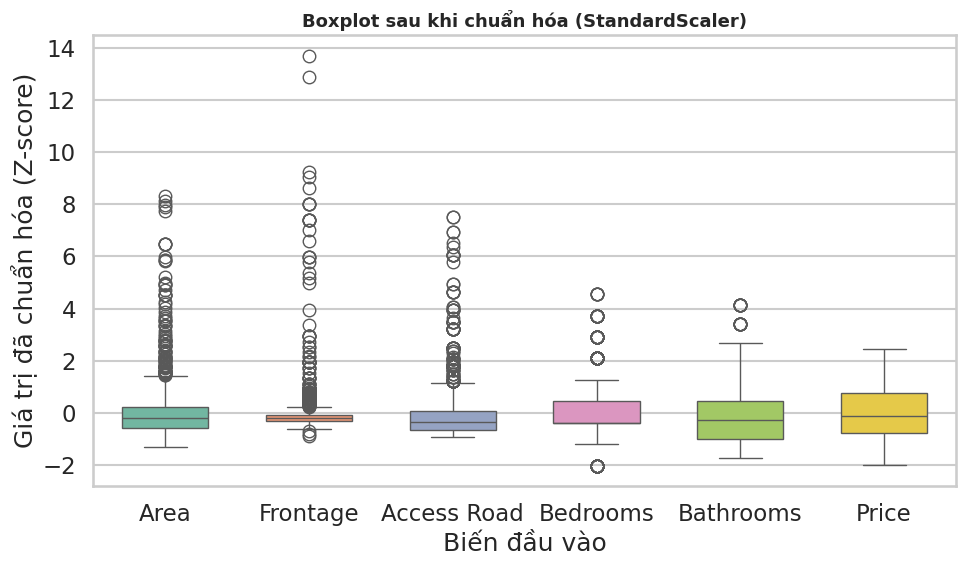

In [234]:
# Vẽ Boxplot sau khi chuẩn hóa
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
sns.boxplot(data=vietnam_housing_clean[cols_to_scale], palette="Set2", width=0.6)
plt.title("Boxplot sau khi chuẩn hóa (StandardScaler)", fontsize=13, fontweight="bold")
plt.ylabel("Giá trị đã chuẩn hóa (Z-score)")
plt.xlabel("Biến đầu vào")
plt.tight_layout()
plt.show()

Trước / Sau: 1772 / 1336


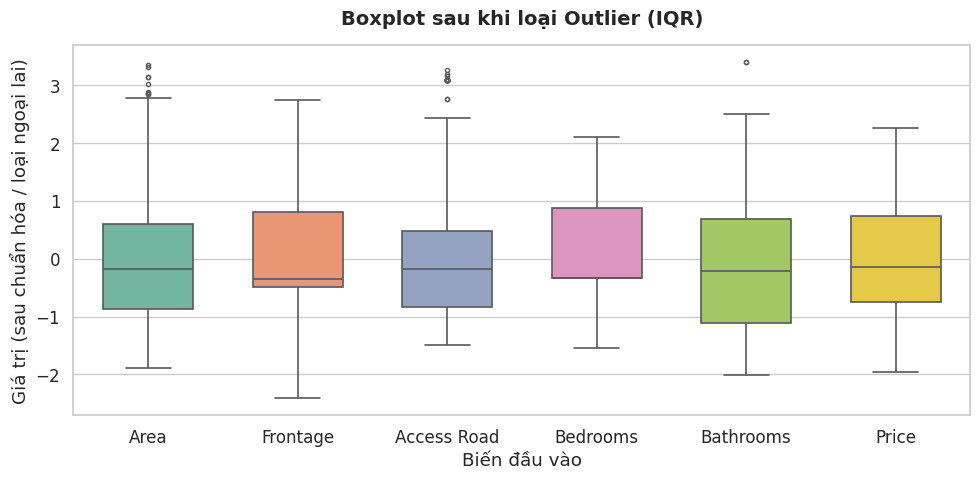

In [235]:
cols = ['Area','Frontage','Access Road','Bedrooms','Bathrooms']

mask = np.ones(len(vietnam_housing_clean), bool)
for c in cols:
    q1, q3 = vietnam_housing_clean[c].quantile([0.25, 0.75])
    iqr = q3 - q1
    mask &= (vietnam_housing_clean[c] >= q1 - 1.5*iqr) & (vietnam_housing_clean[c] <= q3 + 1.5*iqr)

vietnam_housing_clean = vietnam_housing_clean[mask].copy()
print("Trước / Sau:", len(mask), "/", len(vietnam_housing_clean))

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scale_cols = ['Area','Frontage','Access Road','Bedrooms','Bathrooms','Price']
vietnam_housing_clean[scale_cols] = scaler.fit_transform(vietnam_housing_clean[scale_cols])

## Vẽ Boxplot sau khi loại outlier
# Thiết lập style chung
sns.set(style="whitegrid", palette="Set2", font_scale=1.1)
# Vẽ boxplot dọc
plt.figure(figsize=(10, 5))
sns.boxplot(data=vietnam_housing_clean[scale_cols], width=0.6, fliersize=3, linewidth=1.2)
# Thêm tiêu đề và nhãn trục
plt.title("Boxplot sau khi loại Outlier (IQR)", fontsize=14, fontweight="bold", pad=15)
plt.ylabel("Giá trị (sau chuẩn hóa / loại ngoại lai)")
plt.xlabel("Biến đầu vào")
# Làm gọn bố cục và hiển thị
plt.tight_layout()
plt.show()


In [236]:
scaler.__dict__

{'with_mean': True,
 'with_std': True,
 'copy': True,
 'feature_names_in_': array(['Area', 'Frontage', 'Access Road', 'Bedrooms', 'Bathrooms',
        'Price'], dtype=object),
 'n_features_in_': 6,
 'n_samples_seen_': np.int64(1336),
 'mean_': array([-0.2292032 , -0.21829202, -0.2704766 , -0.15175175, -0.08962213,
        -0.11046068]),
 'var_': array([0.22841597, 0.02471643, 0.18867442, 0.45437266, 0.66240871,
        0.91312352]),
 'scale_': array([0.47792883, 0.15721461, 0.43436669, 0.6740717 , 0.81388495,
        0.95557497])}

In [237]:
vietnam_housing_clean[['Frontage','Access Road']].describe()


Frontage   Access Road
count  1.336000e+03  1.336000e+03
mean  -4.121786e-17 -8.775416e-17
std    1.000374e+00  1.000374e+00
min   -2.415696e+00 -1.498026e+00
25%   -4.822593e-01 -8.409418e-01
50%   -3.533635e-01 -1.838580e-01
75%    8.066985e-01  4.732257e-01
max    2.740135e+00  3.265832e+00

In [238]:
vietnam_housing_clean[['Frontage','Access Road']].describe()


Frontage   Access Road
count  1.336000e+03  1.336000e+03
mean  -4.121786e-17 -8.775416e-17
std    1.000374e+00  1.000374e+00
min   -2.415696e+00 -1.498026e+00
25%   -4.822593e-01 -8.409418e-01
50%   -3.533635e-01 -1.838580e-01
75%    8.066985e-01  4.732257e-01
max    2.740135e+00  3.265832e+00

# Vietnam_housing_test

In [239]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Sao chép dữ liệu để không làm thay đổi bản gốc
vietnam_housing_test = pd.DataFrame(vietnam_housing_test)
vietnam_housing_test_clean = vietnam_housing_test.copy()

def find_col(df, name):
    for cand in (name, name.replace(' ', '_'), name.replace(' ', '_').lower()):
        if cand in df.columns:
            return cand
    return None

# Hàm mã hóa hướng an toàn (tạo cột sin/cos với tên có gạch dưới)
def encode_direction(df, name):
    angle_map = {
        'Đông': 0, 'Đông Nam': 45, 'Nam': 90, 'Tây Nam': 135,
        'Tây': 180, 'Tây Bắc': 225, 'Bắc': 270, 'Đông Bắc': 315
    }
    col = find_col(df, name)
    out_base = name.replace(' ', '_')
    if col is None:
        print(f"Warning: direction column not found: {name} -> creating default {out_base}_sin/{out_base}_cos")
        df[out_base + '_sin'] = 0.0
        df[out_base + '_cos'] = 1.0
        return df
    angles = df[col].map(angle_map).fillna(0).astype(float)
    df[out_base + '_sin'] = np.sin(np.deg2rad(angles))
    df[out_base + '_cos'] = np.cos(np.deg2rad(angles))
    return df

# Mã hóa hướng nhà & ban công -
vietnam_housing_test_clean = encode_direction(vietnam_housing_test_clean, 'House direction')
vietnam_housing_test_clean = encode_direction(vietnam_housing_test_clean, 'Balcony direction')

# Mã hóa CÁC BIẾN PHÂN LOẠI KHÁC phân loại khác 
# --- Mã hóa các biến phân loại khác ---
for src in ['Legal status', 'Furniture state']:
    col = find_col(vietnam_housing_test_clean, src)
    out_col = src.replace(' ', '_')
    if col:
        le = LabelEncoder()
        vietnam_housing_test_clean[out_col] = le.fit_transform(vietnam_housing_test_clean[col].astype(str))
    else:
        print(f" Warning: categorical column not found: {src}")

# --- One-Hot Encoding (sử dụng cột mới có dấu gạch dưới) ---
vietnam_housing_test_clean = pd.get_dummies(
    vietnam_housing_test_clean,
    columns=['Legal_status', 'Furniture_state'],
    drop_first=True)

In [240]:
vietnam_housing_test_clean.loc[:, cols_to_scale] = scaler.transform(
    vietnam_housing_test_clean[cols_to_scale]
)

print("Mean sau chuẩn hóa (TEST):")
print(vietnam_housing_test_clean[cols_to_scale].mean().round(2))

print("Std sau chuẩn hóa (TEST):")
print(vietnam_housing_test_clean[cols_to_scale].std().round(2))


Mean sau chuẩn hóa (TEST):
Area           152.07
Frontage        36.61
Access Road     18.82
Bedrooms         5.43
Bathrooms        4.24
Price            5.85
dtype: float64
Std sau chuẩn hóa (TEST):
Area           102.62
Frontage        31.04
Access Road     19.78
Bedrooms         1.64
Bathrooms        1.60
Price            2.37
dtype: float64


/tmp/ipykernel_5573/789269937.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 4.67569214  6.15921384  4.67569214  3.19217043  4.67569214  6.15921384
  6.15921384  6.15921384  4.67569214  4.67569214  6.15921384  6.15921384
  4.67569214  6.15921384  3.19217043  9.12625725  4.67569214  3.19217043
  4.67569214  3.19217043  4.67569214  4.67569214  4.67569214  4.67569214
  1.70864873  3.19217043  6.15921384  7.64273555  4.67569214  6.15921384
  4.67569214  4.67569214  6.15921384  7.64273555  3.19217043  6.15921384
  6.15921384  4.67569214  4.67569214  4.67569214  4.67569214  4.67569214
  3.19217043  4.67569214  4.67569214  6.15921384  4.67569214  4.67569214
  4.67569214  1.70864873  4.67569214  6.15921384  4.67569214  6.15921384
  6.15921384  4.67569214  6.15921384  6.15921384  6.15921384  4.67569214
  3.19217043  6.15921384  6.15921384  4.67569214  4.67569214  6.15921384
  4.67569214  4.67569214  4.67569214  4.675

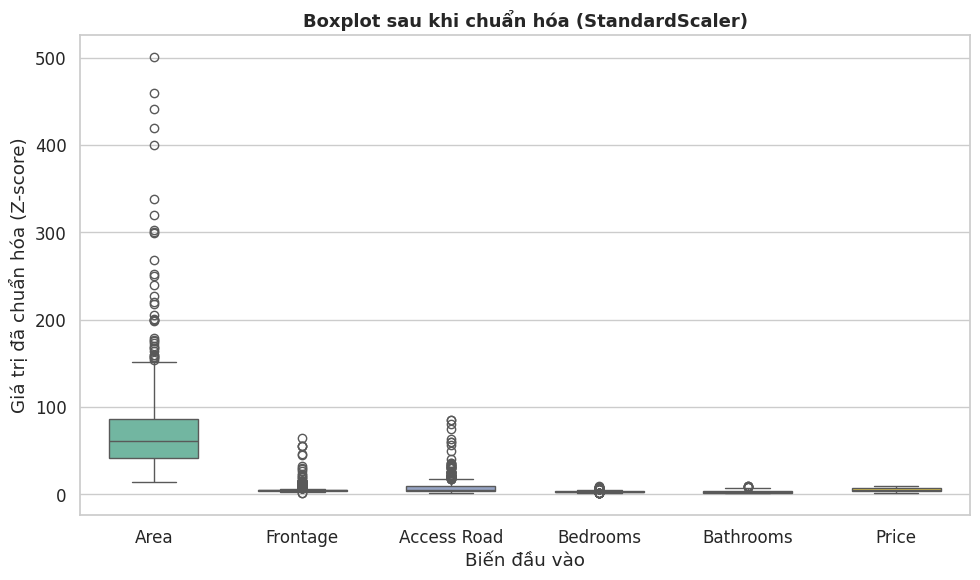

In [241]:
# Vẽ Boxplot sau khi chuẩn hóa
plt.figure(figsize=(10,6))
sns.boxplot(data=vietnam_housing_test[cols_to_scale], palette="Set2", width=0.6)
plt.title("Boxplot sau khi chuẩn hóa (StandardScaler)", fontsize=13, fontweight="bold")
plt.ylabel("Giá trị đã chuẩn hóa (Z-score)")
plt.xlabel("Biến đầu vào")
plt.tight_layout()
plt.show()

Trước / Sau: 874 / 666


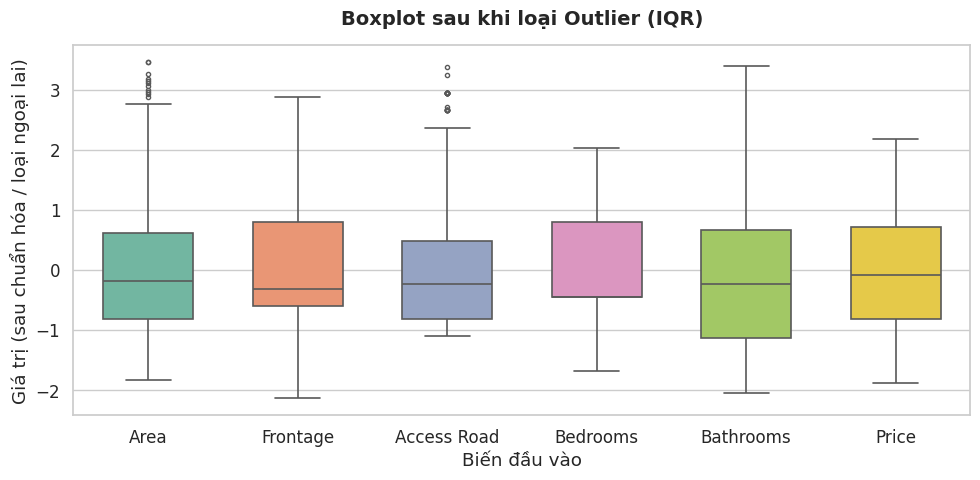

In [242]:
cols = ['Area','Frontage','Access Road','Bedrooms','Bathrooms']

mask = np.ones(len(vietnam_housing_test_clean), bool)
for c in cols:
    q1, q3 = vietnam_housing_test_clean[c].quantile([0.25, 0.75])
    iqr = q3 - q1
    mask &= (vietnam_housing_test_clean[c] >= q1 - 1.5*iqr) & (vietnam_housing_test_clean[c] <= q3 + 1.5*iqr)

vietnam_housing_test_clean = vietnam_housing_test_clean[mask].copy()
print("Trước / Sau:", len(mask), "/", len(vietnam_housing_test_clean))

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scale_cols = ['Area','Frontage','Access Road','Bedrooms','Bathrooms','Price']
vietnam_housing_test_clean[scale_cols] = scaler.fit_transform(vietnam_housing_test_clean[scale_cols])

## Vẽ Boxplot sau khi loại outlier
# Thiết lập style chung
sns.set(style="whitegrid", palette="Set2", font_scale=1.1)
# Vẽ boxplot dọc
plt.figure(figsize=(10, 5))
sns.boxplot(data=vietnam_housing_test_clean[scale_cols], width=0.6, fliersize=3, linewidth=1.2)
# Thêm tiêu đề và nhãn trục
plt.title("Boxplot sau khi loại Outlier (IQR)", fontsize=14, fontweight="bold", pad=15)
plt.ylabel("Giá trị (sau chuẩn hóa / loại ngoại lai)")
plt.xlabel("Biến đầu vào")
# Làm gọn bố cục và hiển thị
plt.tight_layout()
plt.show()


In [243]:
scaler.__dict__

{'with_mean': True,
 'with_std': True,
 'copy': True,
 'feature_names_in_': array(['Area', 'Frontage', 'Access Road', 'Bedrooms', 'Bathrooms',
        'Price'], dtype=object),
 'n_features_in_': 6,
 'n_samples_seen_': np.int64(666),
 'mean_': array([128.15724849,  29.53273082,  13.99015662,   5.20806704,
          4.107922  ,   5.62192666]),
 'var_': array([2.88964961e+03, 2.08300210e+01, 6.30500099e+01, 1.43825248e+00,
        1.84084660e+00, 5.12596851e+00]),
 'scale_': array([53.75546123,  4.56399179,  7.94040364,  1.19927164,  1.35677802,
         2.26406018])}

In [244]:
vietnam_housing_test_clean[['Frontage','Access Road']].describe()


Frontage   Access Road
count  6.660000e+02  6.660000e+02
mean   1.600321e-17 -2.133762e-16
std    1.000752e+00  1.000752e+00
min   -2.138855e+00 -1.103604e+00
25%   -5.918734e-01 -8.136687e-01
50%   -3.131380e-01 -2.337983e-01
75%    8.018039e-01  4.910396e-01
max    2.892320e+00  3.390391e+00

# THỐNG KÊ MÔ TẢ

In [245]:
from IPython.display import display  

print("Kích thước dữ liệu:", vietnam_housing_clean.shape)
print("\n== Thông tin cột ==")
display(pd.DataFrame({
    "dtype": vietnam_housing_clean.dtypes.astype(str),
    "missing": vietnam_housing_clean.isna().sum(),
    "missing_rate": (vietnam_housing_clean.isna().mean()*100).round(2).astype(str) + "%"
}).sort_index())

Kích thước dữ liệu: (1336, 18)

== Thông tin cột ==


dtype  missing missing_rate
Access Road            float64        0         0.0%
Address                 object        0         0.0%
Area                   float64        0         0.0%
Balcony direction       object        0         0.0%
Balcony_direction_cos  float64        0         0.0%
Balcony_direction_sin  float64        0         0.0%
Bathrooms              float64        0         0.0%
Bedrooms               float64        0         0.0%
Floors                   int64        0         0.0%
Frontage               float64        0         0.0%
Furniture state         object        0         0.0%
Furniture_state_1         bool        0         0.0%
House direction         object        0         0.0%
House_direction_cos    float64        0         0.0%
House_direction_sin    float64        0         0.0%
Legal status            object        0         0.0%
Legal_status_1            bool        0         0.0%
Price                  float64        0         0.0%

In [246]:
#Thống kê mô tả cho biến số
num_cols = vietnam_housing_clean.select_dtypes(include=[np.number]).columns.tolist()
print(f"\n== Thống kê biến số ({len(num_cols)} cột) ==")
display(vietnam_housing_clean[num_cols].describe().T)


== Thống kê biến số (11 cột) ==


count          mean       std       min           25%  \
Area                   1336.0  3.855864e-17  1.000374 -1.895406 -8.690546e-01   
Frontage               1336.0 -4.121786e-17  1.000374 -2.415696 -4.822593e-01   
Access Road            1336.0 -8.775416e-17  1.000374 -1.498026 -8.409418e-01   
Floors                 1336.0  3.286677e+00  1.243772  1.000000  2.000000e+00   
Bedrooms               1336.0  6.648042e-18  1.000374 -1.551343 -3.321699e-01   
Bathrooms              1336.0  9.307259e-18  1.000374 -2.014182 -1.111483e+00   
Price                  1336.0  1.063687e-17  1.000374 -1.962483 -7.418153e-01   
House_direction_sin    1336.0  1.497006e-02  0.444442 -1.000000  0.000000e+00   
House_direction_cos    1336.0  6.212575e-01  0.645559 -1.000000  6.123234e-17   
Balcony_direction_sin  1336.0  1.946108e-02  0.450962 -1.000000  0.000000e+00   
Balcony_direction_cos  1336.0  6.137725e-01  0.648078 -1.000000  6.123234e-17   

                            50%       75%       max  
Area                  -0.171136  0.608892  3.359514  
Frontage              -0.353364  0.806698  2.740135  
Access Road           -0.183858  0.473226  3.265832  
Floors                 3.000000  4.000000  7.000000  
Bedrooms              -0.332170  0.887003  2.106176  
Bathrooms             -0.208783  0.693917  3.402015  
Price                 -0.138523  0.739419  2.262906  
House_direction_sin    0.000000  0.000000  1.000000  
House_direction_cos    1.000000  1.000000  1.000000  
Balcony_direction_sin  0.000000  0.000000  1.000000  
Balcony_direction_cos  1.000000  1.000000  1.000000

In [247]:
#Thống kê cho biến phân loại (nếu còn)
cat_cols = vietnam_housing_clean.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
if cat_cols:
    print(f"\n== Thống kê biến phân loại ({len(cat_cols)} cột) ==")
    def cat_summary(s: pd.Series):
        vc = s.value_counts(dropna=False)
        return pd.Series({
            "n_unique": s.nunique(dropna=False),
            "top": vc.index[0],
            "top_freq": int(vc.iloc[0]),
            "top_freq_rate": f"{(vc.iloc[0]/len(s)*100):.2f}%"
        })
    display(pd.DataFrame({c: cat_summary(vietnam_housing_clean[c]) for c in cat_cols}).T)
else:
    print("\n== Không còn biến phân loại ==")


== Thống kê biến phân loại (7 cột) ==


n_unique                                                top  \
Address               1043  Đường Thạch Bàn, Phường Thạch Bàn, Long Biên, ...   
House direction          8                                         Đông - Nam   
Balcony direction        8                                         Đông - Nam   
Legal status             2                                   Have certificate   
Furniture state          2                                               Full   
Legal_status_1           2                                              False   
Furniture_state_1        2                                               True   

                  top_freq top_freq_rate  
Address                 10         0.75%  
House direction        269        20.13%  
Balcony direction      264        19.76%  
Legal status          1319        98.73%  
Furniture state        803        60.10%  
Legal_status_1        1319        98.73%  
Furniture_state_1      803        60.10%

In [248]:
#Ma trận tương quan nhanh
print("\n== Tương quan giữa các biến số (Top 10 cặp mạnh nhất tuyệt đối) ==")
corr = vietnam_housing_clean[num_cols].corr(numeric_only=True)
corr_abs = corr.abs().where(~np.eye(len(corr), dtype=bool))
pairs = (
    corr_abs.unstack()
    .dropna()
    .sort_values(ascending=False)
    .head(10)
)
display(pairs.to_frame("abs_corr"))


== Tương quan giữa các biến số (Top 10 cặp mạnh nhất tuyệt đối) ==


abs_corr
House_direction_sin   Balcony_direction_sin  0.940359
Balcony_direction_sin House_direction_sin    0.940359
Balcony_direction_cos House_direction_cos    0.935619
House_direction_cos   Balcony_direction_cos  0.935619
Bedrooms              Bathrooms              0.657207
Bathrooms             Bedrooms               0.657207
                      Floors                 0.652365
Floors                Bathrooms              0.652365
Bedrooms              Floors                 0.503983
Floors                Bedrooms               0.503983

# Vẽ pairplot giữa các biến có tương quan cao nhất

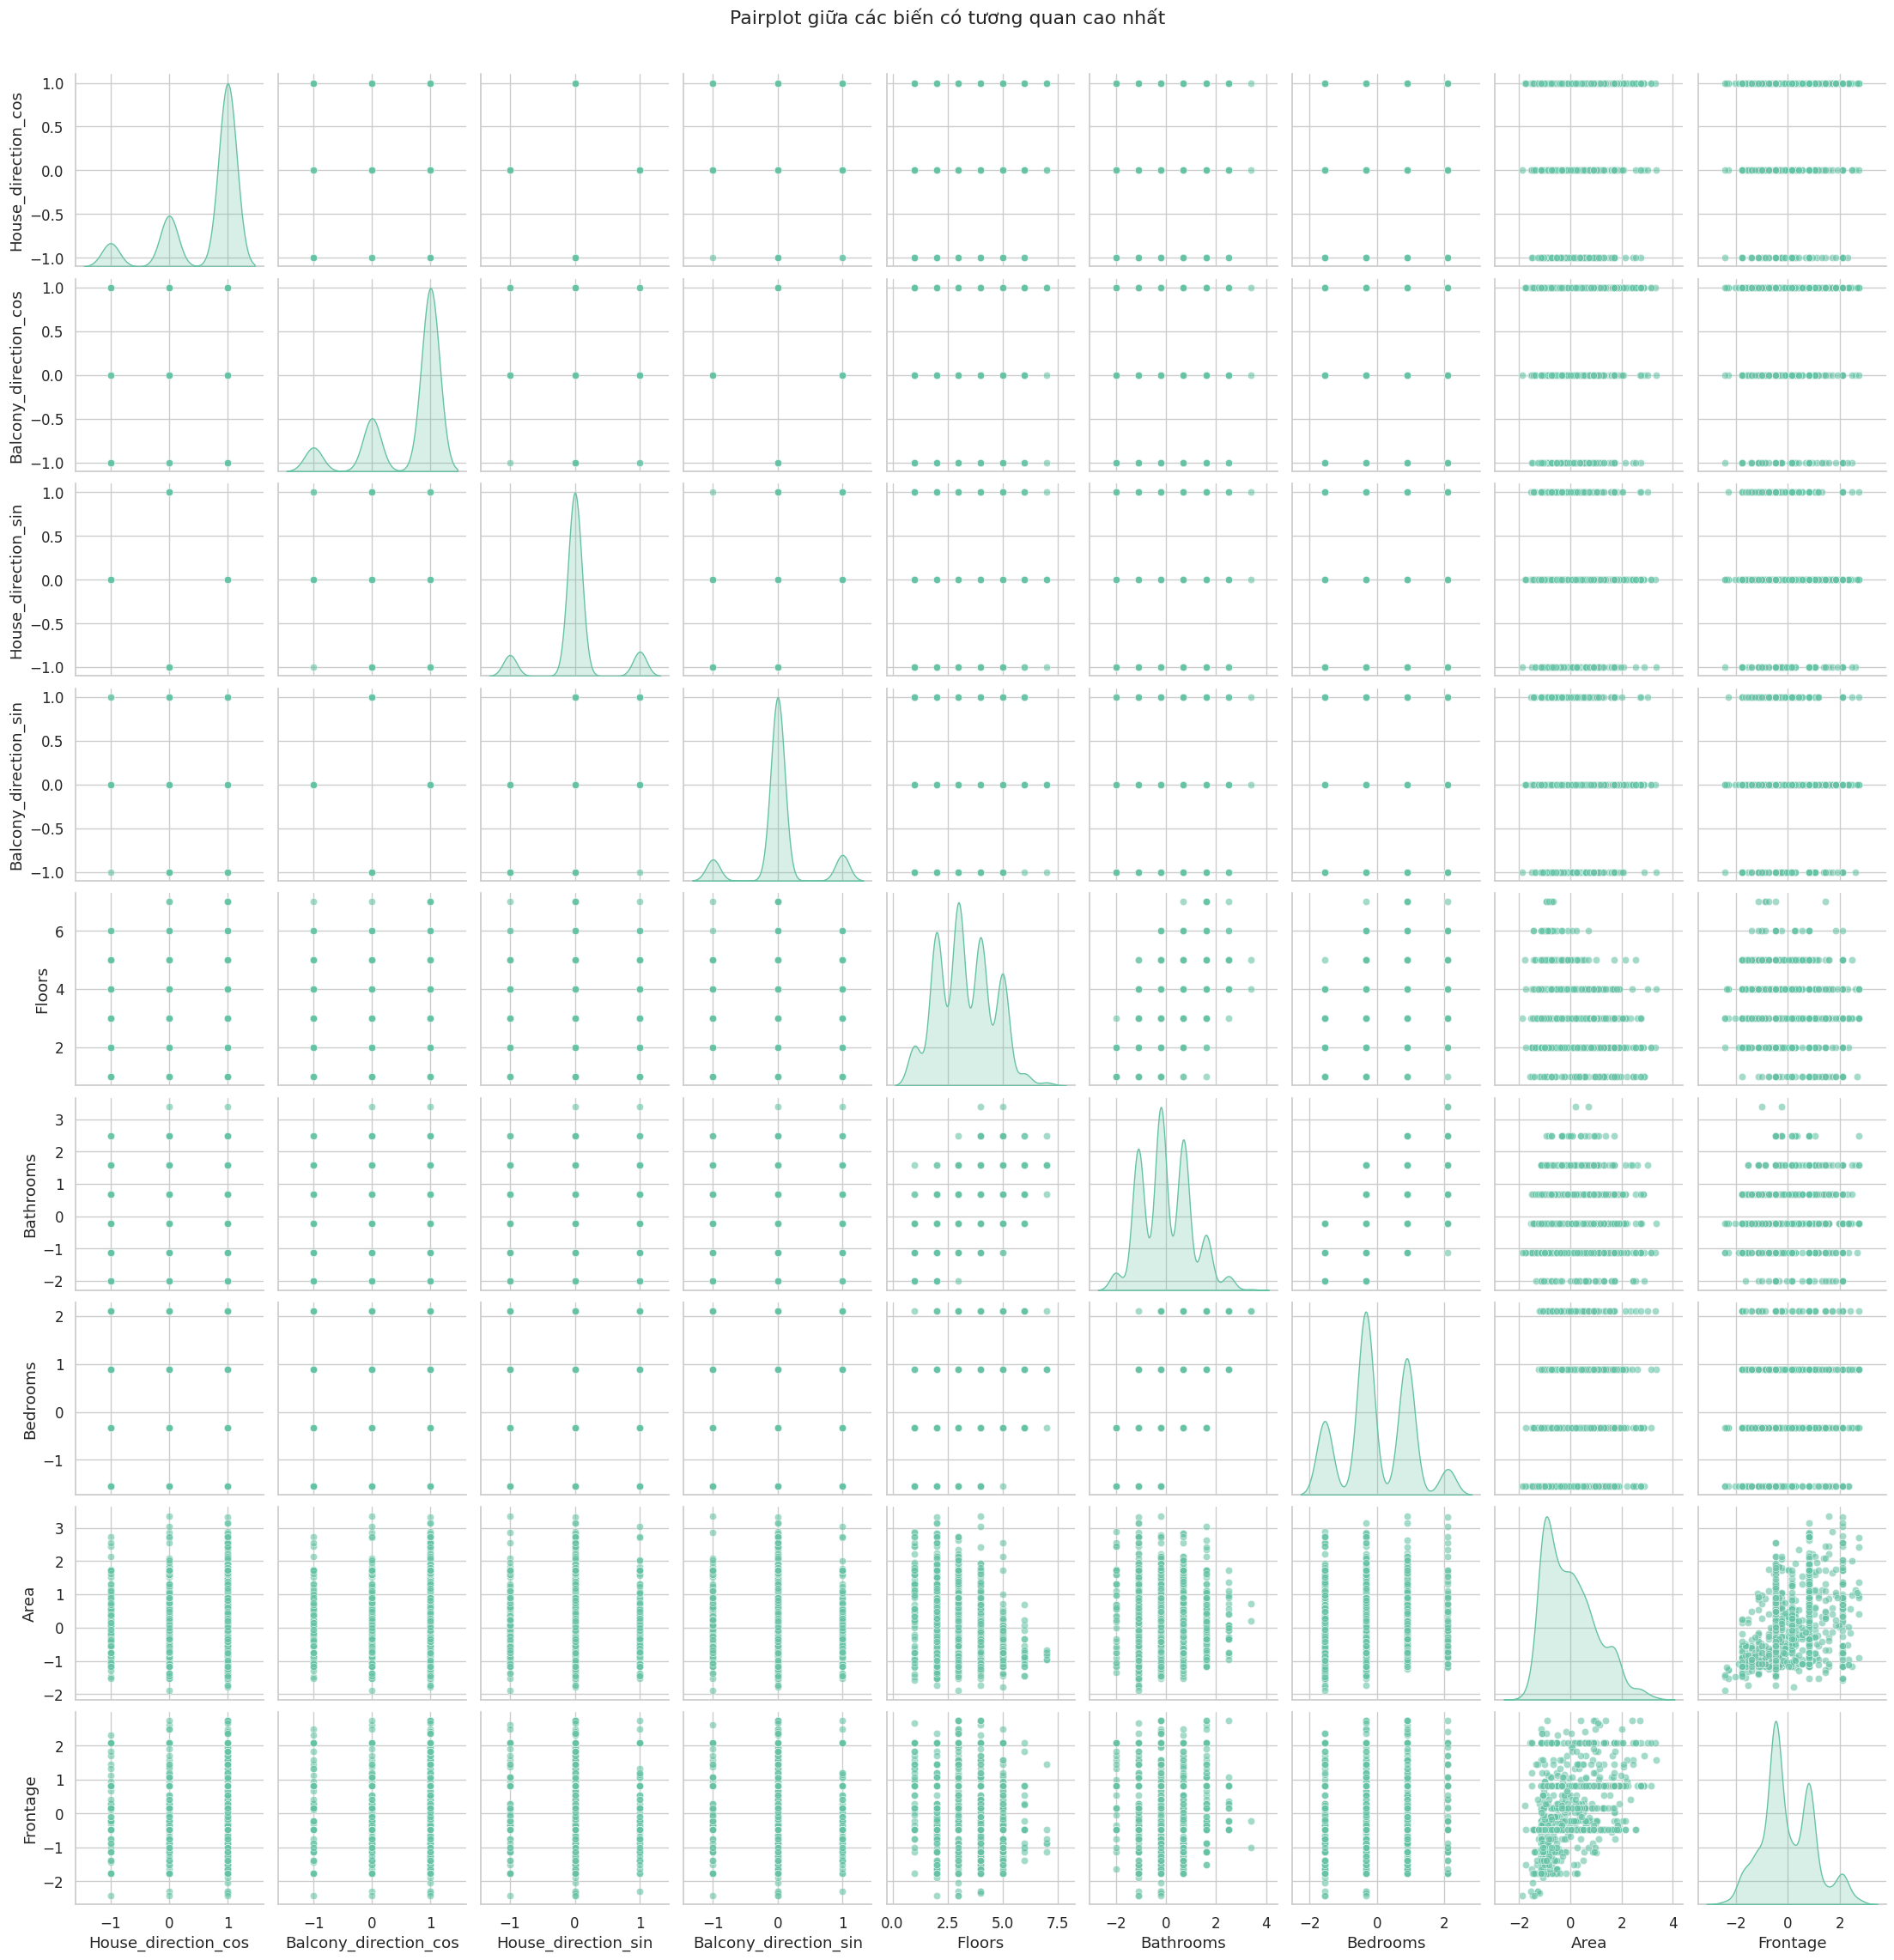

In [249]:
import seaborn as sns
import matplotlib.pyplot as plt


# Danh sách các biến có tương quan cao 
strong_corr_cols = ['House_direction_cos', 'Balcony_direction_cos',
                    'House_direction_sin', 'Balcony_direction_sin',
                    'Floors', 'Bathrooms', 'Bedrooms', 'Area', 'Frontage']

# Vẽ pairplot
sns.pairplot(vietnam_housing_clean[strong_corr_cols], diag_kind='kde', plot_kws={'alpha':0.6})
plt.suptitle("Pairplot giữa các biến có tương quan cao nhất", y=1.02)
plt.show()

**VISUALIZATION**

**Biểu đồ phân phối (Histogram + KDE) cho các biến số**

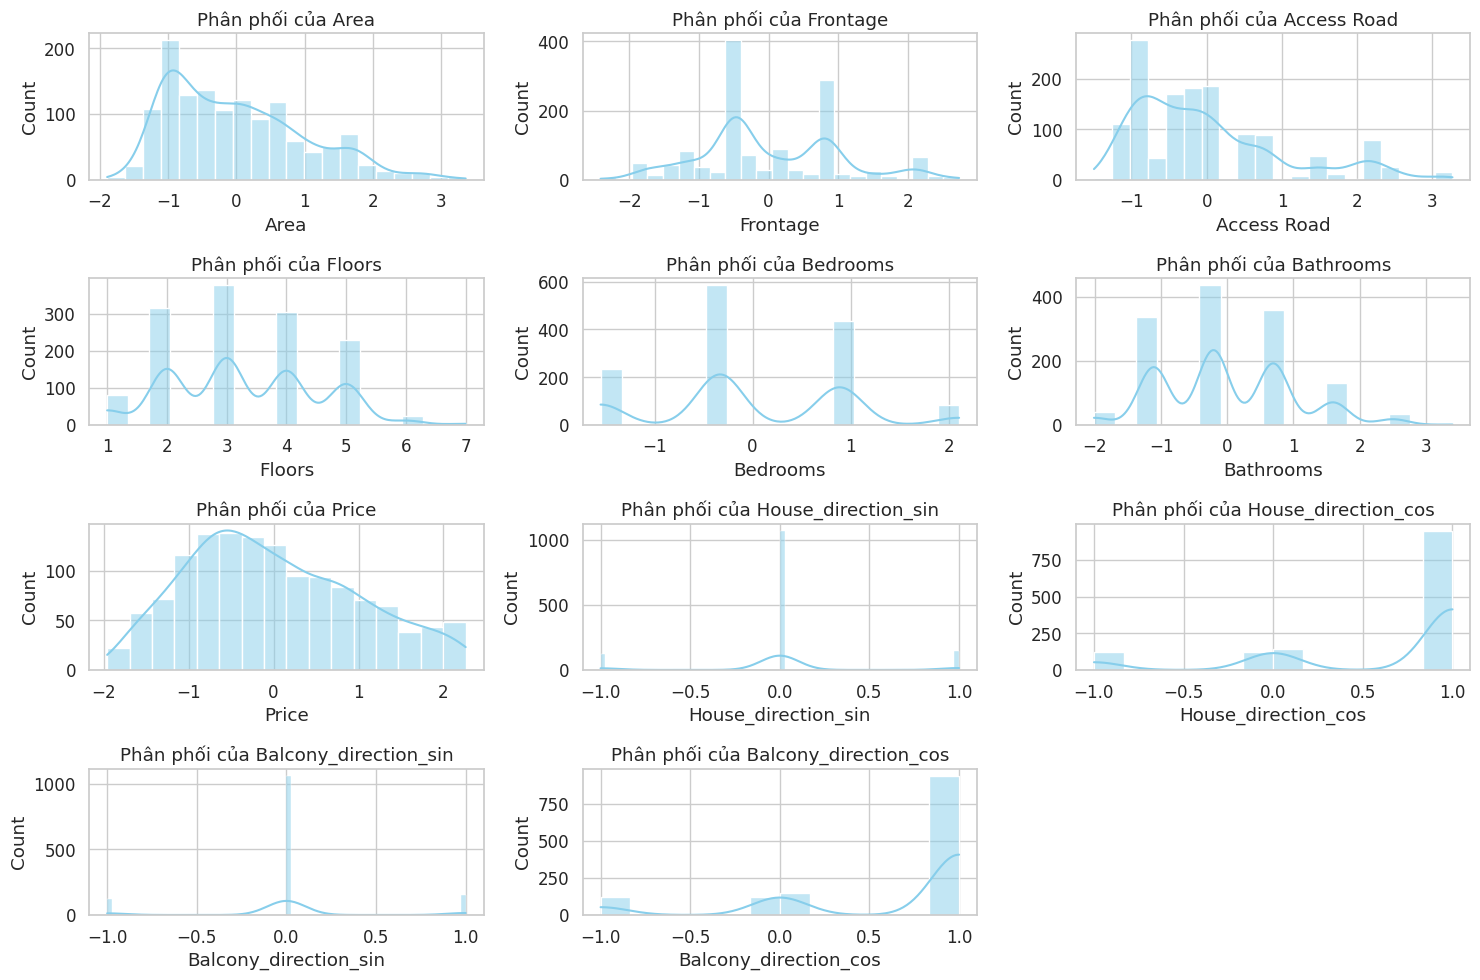

In [250]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = vietnam_housing_clean.select_dtypes(include=[np.number]).columns.tolist()

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols):
    plt.subplot((len(num_cols) + 2)//3, 3, i + 1)
    sns.histplot(vietnam_housing_clean[col], kde=True, color='skyblue')
    plt.title(f'Phân phối của {col}')
plt.tight_layout()
plt.savefig("phan_phoi_du_lieu.png", dpi=300, bbox_inches='tight')
plt.show()



**Biểu đồ hộp (Boxplot) để phát hiện ngoại lệ**

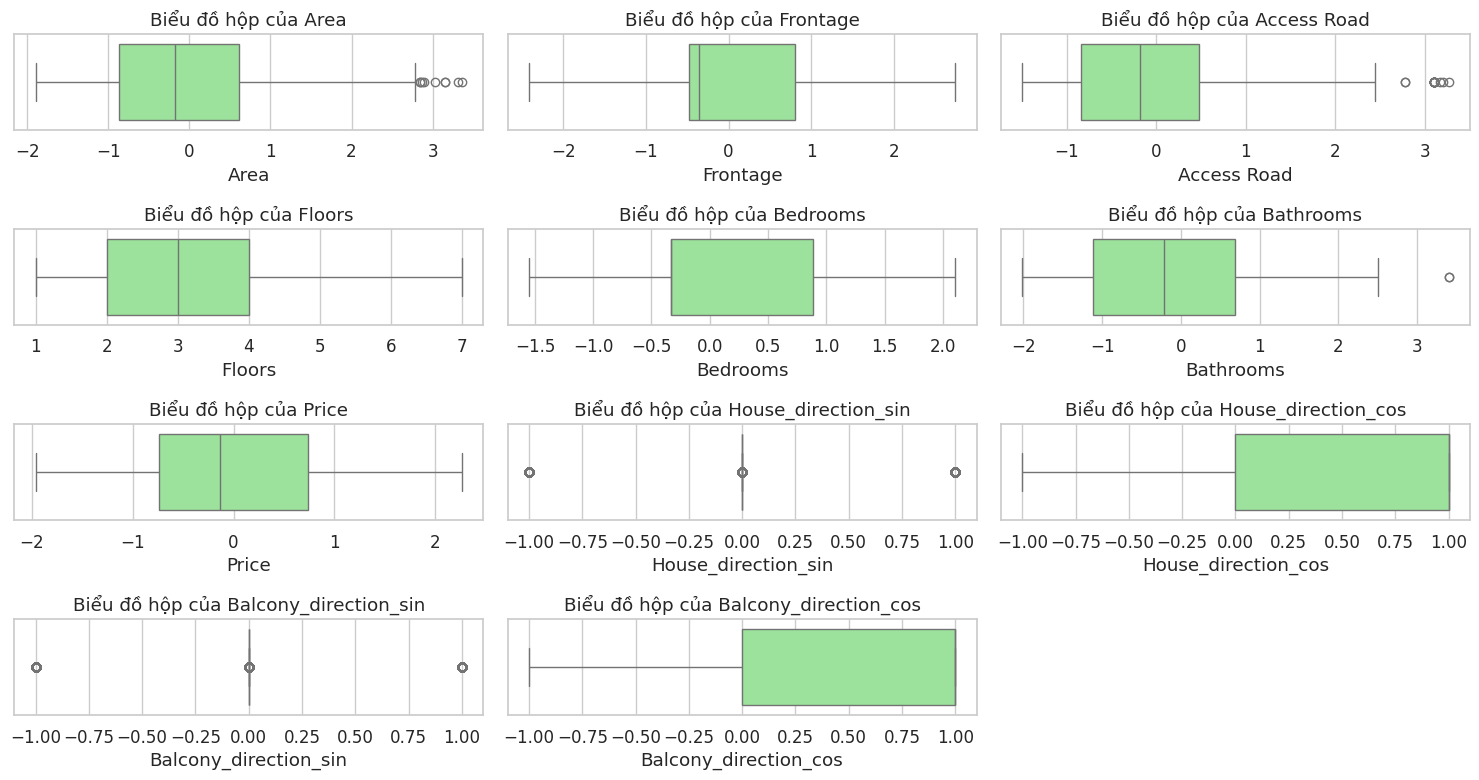

In [251]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(num_cols):
    plt.subplot((len(num_cols) + 2)//3, 3, i + 1)
    sns.boxplot(x=vietnam_housing_clean[col], color='lightgreen')
    plt.title(f'Biểu đồ hộp của {col}')
plt.tight_layout()
plt.show()

**Biểu đồ phân tán (Scatter plot) giữa giá và các biến quan trọng**

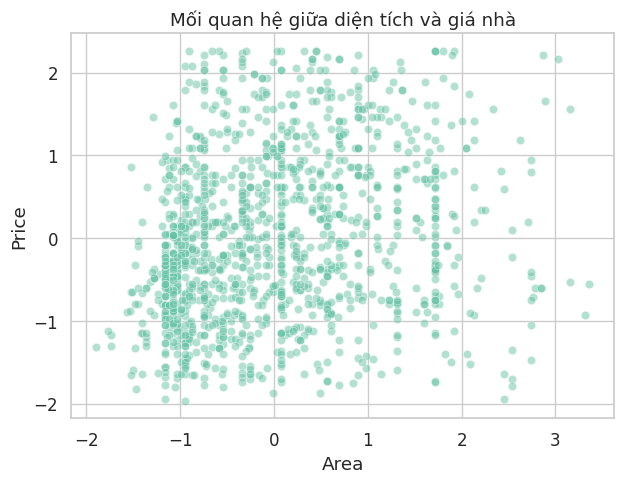

In [252]:
plt.figure(figsize=(7, 5))
sns.scatterplot(x='Area', y='Price', data=vietnam_housing_clean, alpha=0.5)
plt.title('Mối quan hệ giữa diện tích và giá nhà')
plt.show()

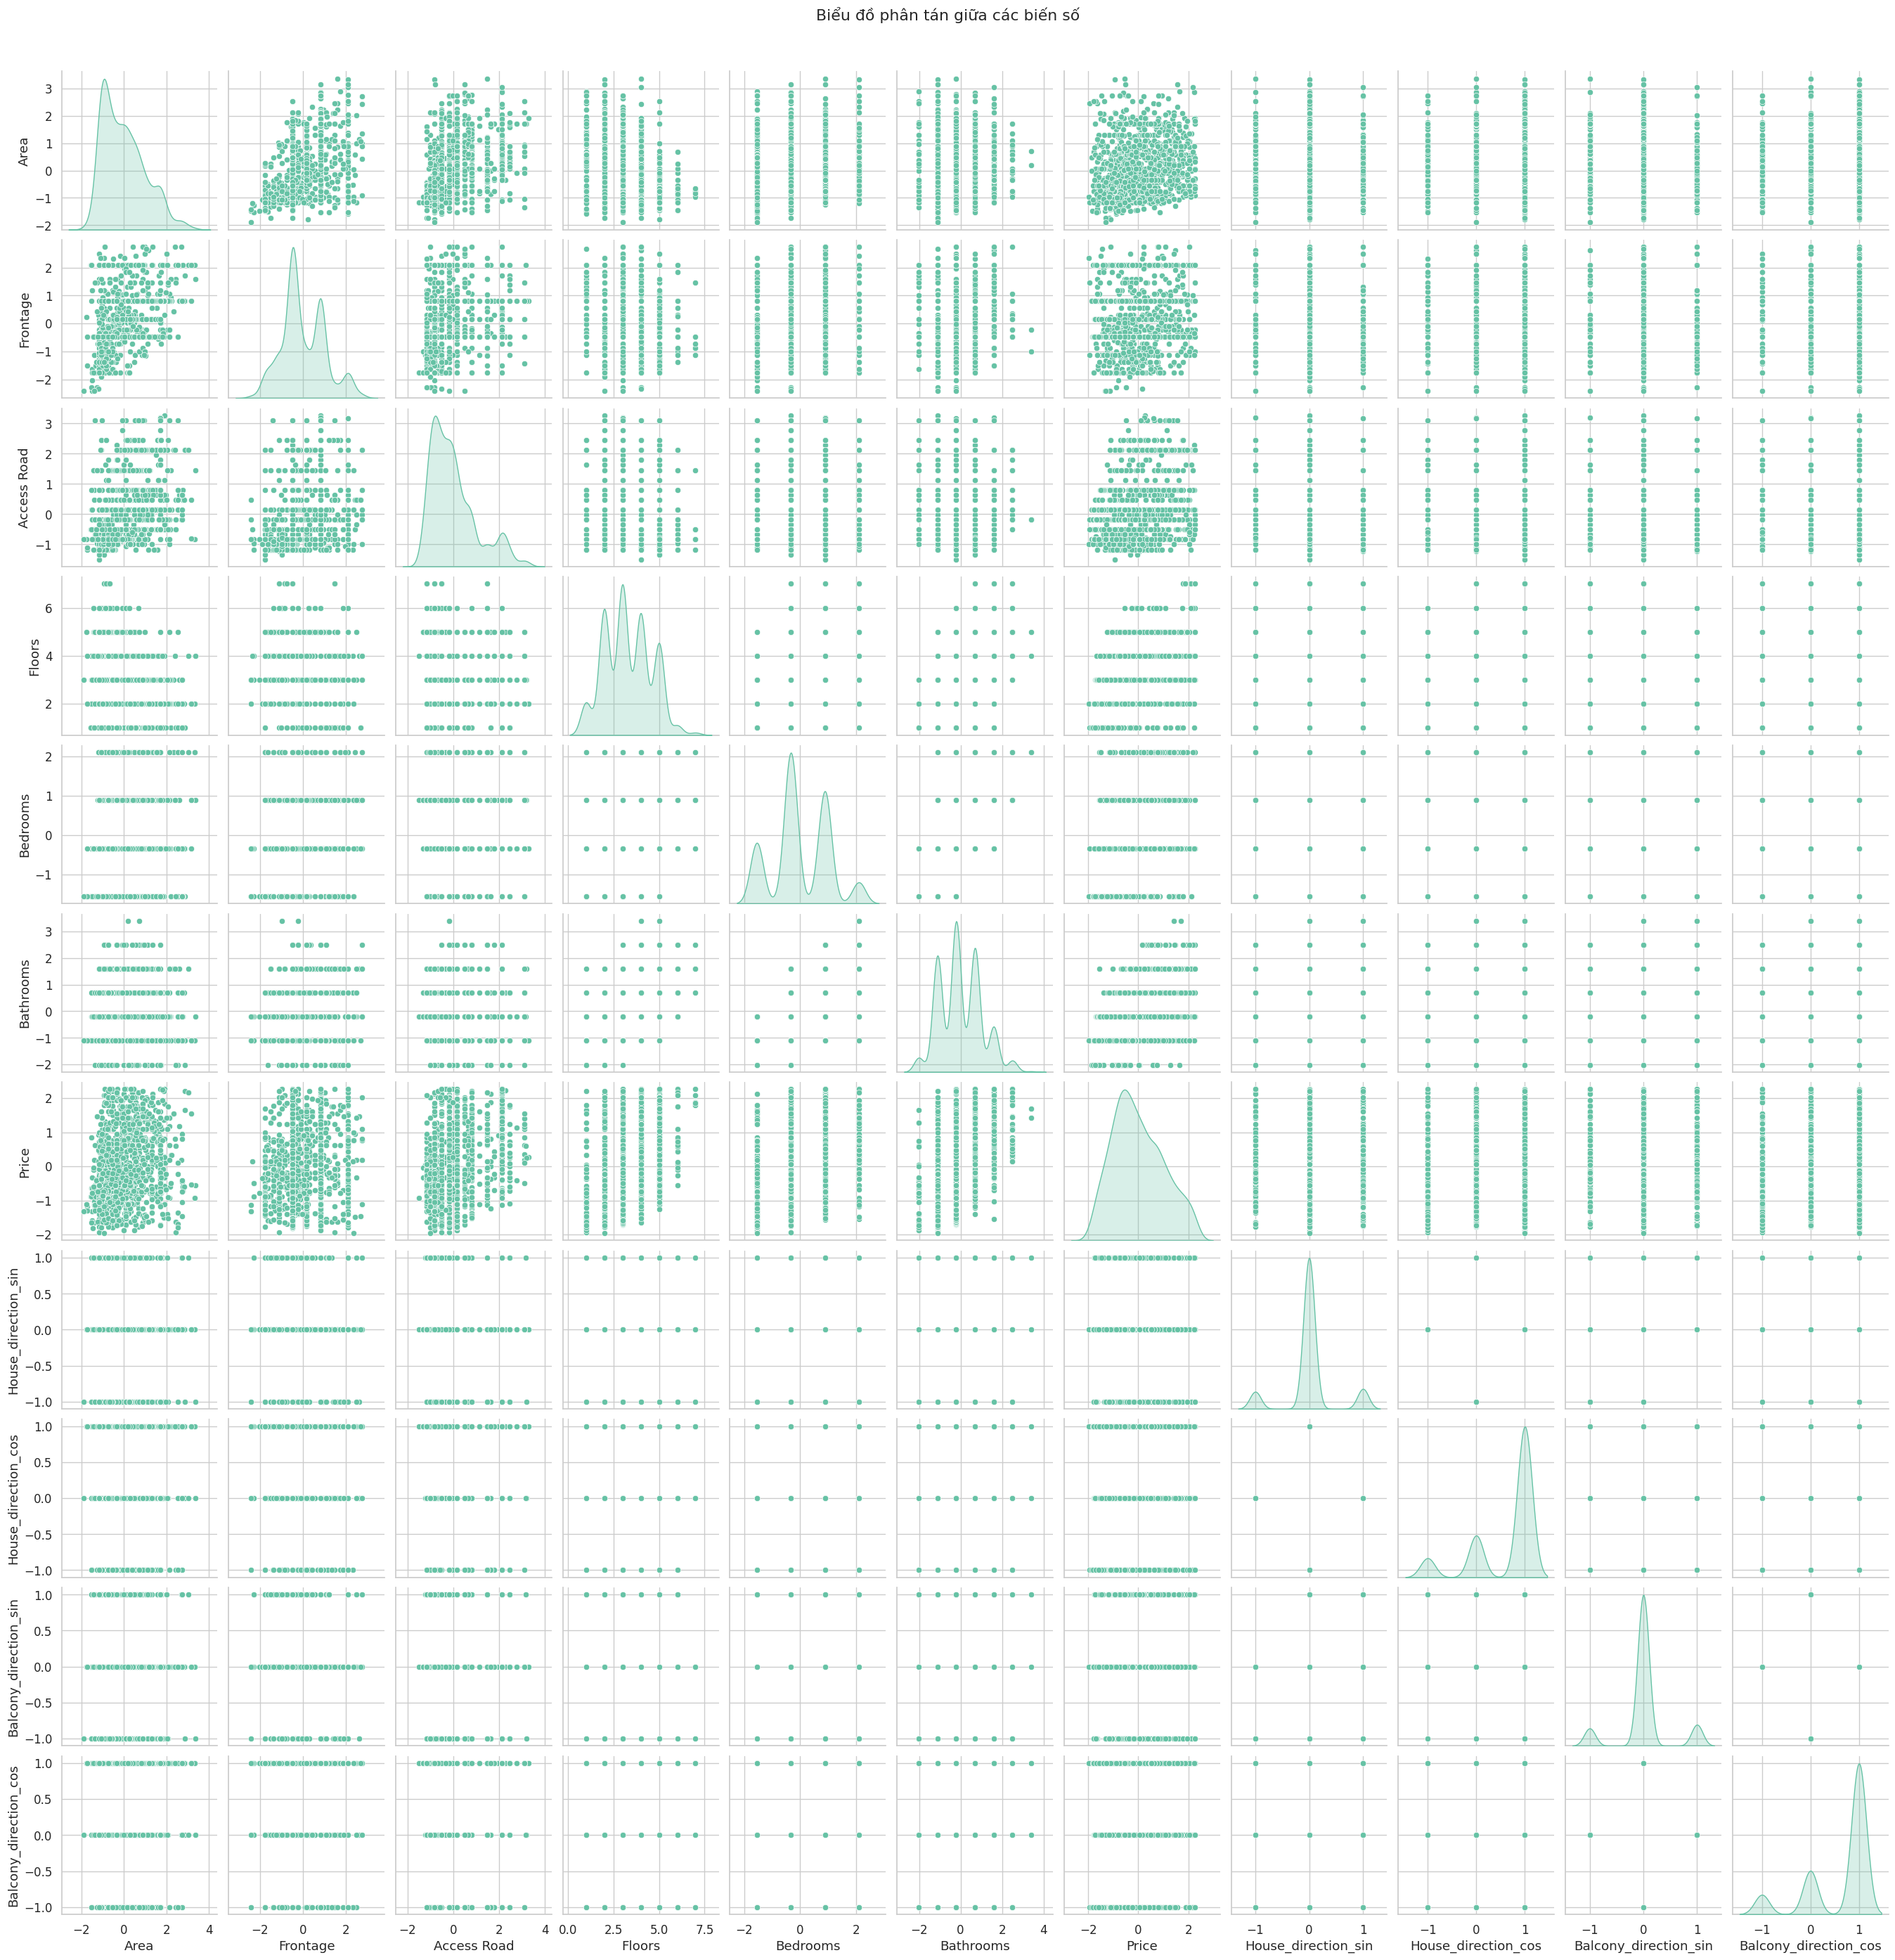

In [253]:
sns.pairplot(vietnam_housing_clean[num_cols], diag_kind='kde')
plt.suptitle('Biểu đồ phân tán giữa các biến số', y=1.02)
plt.show()

**Biểu đồ tương quan (Heatmap)**

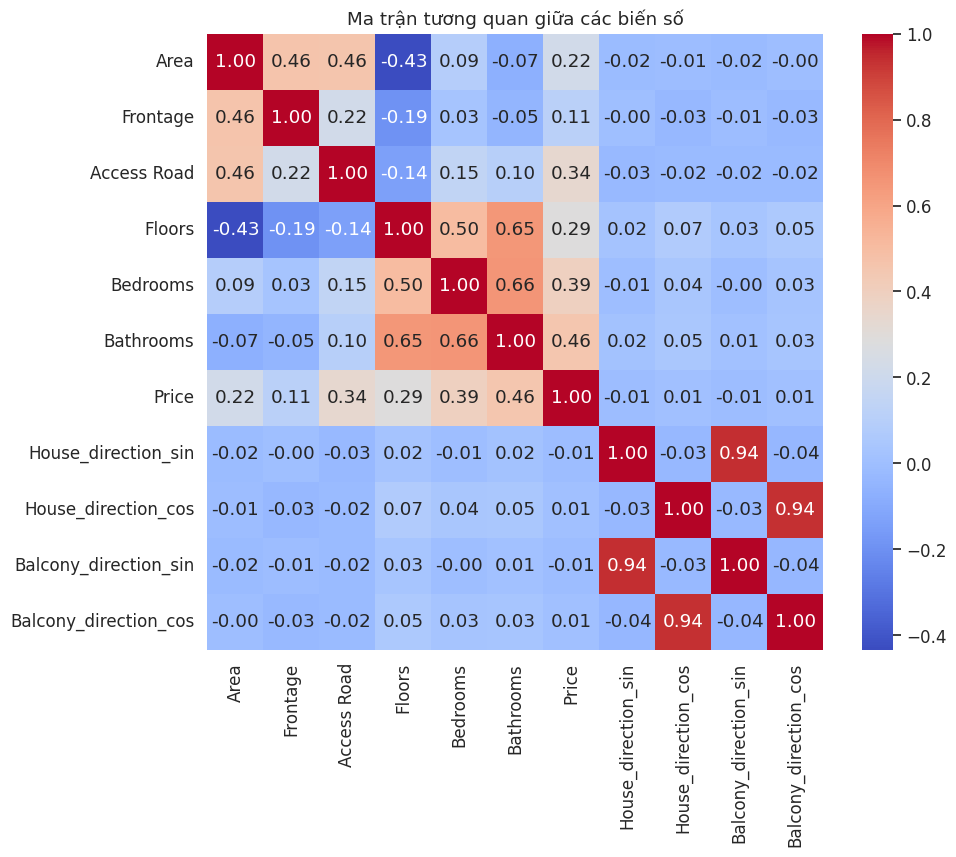

In [254]:
plt.figure(figsize=(10, 8))
corr = vietnam_housing_clean[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Ma trận tương quan giữa các biến số')
plt.show()

## PHÂN CỤM DỮ LIỆU

In [255]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Định nghĩa các cột số và cột phân loại
num_cols = ['Area', 'Access Road', 'Frontage', 'Bedrooms', 'Bathrooms', 'Price',
            'House_direction_sin', 'House_direction_cos',
            'Balcony_direction_sin', 'Balcony_direction_cos','Legal_status_1','Furniture_status_1']



In [256]:
num_cols = [c for c in num_cols if c in vietnam_housing_clean.columns]
X = vietnam_housing_clean[num_cols].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [257]:
# Chạy KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
km_inertias, km_scores = [], []
for k in range(3, 10):
    km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_scaled)
    km_inertias.append(km.inertia_)
    km_scores.append(silhouette_score(X_scaled, km.labels_))
    print(f"k={k} | Inertia={km.inertia_:.2f} | Silhouette={km_scores[-1]:.4f}")


k=3 | Inertia=10409.74 | Silhouette=0.1991
k=4 | Inertia=9011.67 | Silhouette=0.2219
k=5 | Inertia=7784.87 | Silhouette=0.2329
k=6 | Inertia=6914.89 | Silhouette=0.2227
k=7 | Inertia=6080.12 | Silhouette=0.2541


k=8 | Inertia=5745.47 | Silhouette=0.2376
k=9 | Inertia=5469.41 | Silhouette=0.2178


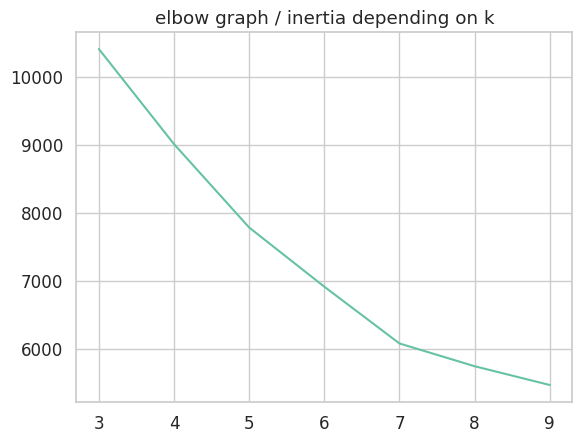

k = 3, Silhouette Score = 0.196
k = 4, Silhouette Score = 0.175
k = 5, Silhouette Score = 0.210
k = 6, Silhouette Score = 0.192
k = 7, Silhouette Score = 0.174
k = 8, Silhouette Score = 0.216
k = 9, Silhouette Score = 0.207


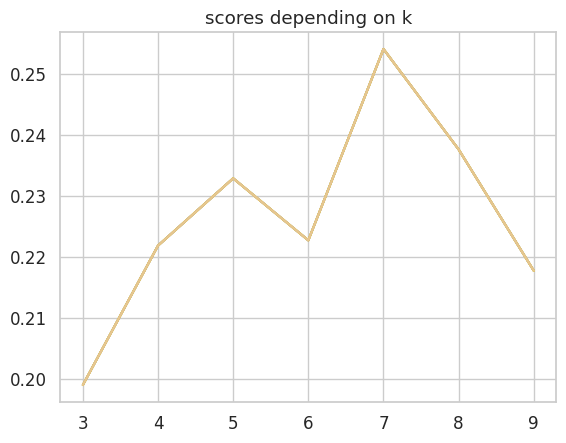

In [258]:
# sns.lineplot(range(3, 10), km_inertias) PHUOCNT
sns.lineplot(x=range(3, 10), y=km_inertias)
plt.title('elbow graph / inertia depending on k')
plt.show()
# Bổ sung kiểm tra bằng Silhouette Score
from sklearn.metrics import silhouette_score
for k in range(3, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    score = silhouette_score(X_scaled, km.labels_)
    print(f"k = {k}, Silhouette Score = {score:.3f}")
    sns.lineplot(x=range(3, 10), y=km_scores)
plt.title('scores depending on k')
plt.show()



In [259]:
# Gán nhãn cho các mẫu dữ liệu dựa vào mô hình K-Means với số cụm là 5 và 6
km = KMeans(n_clusters=4).fit(X_scaled)
#Assign the Cluster Labels to the Data
X['Label'] = km.labels_
clusters = km.labels_
#Info for each cluster
for k in range(4):
 print(f'Cluster nb : {k}')
 print(X[X.Label == k].describe().iloc[:, 1:-1])
 print('\n\n')
 

Cluster nb : 0
       Access Road    Frontage    Bedrooms   Bathrooms       Price  \
count   233.000000  233.000000  233.000000  233.000000  233.000000   
mean      0.077495    0.058937   -0.044382   -0.092556   -0.012699   
std       0.995802    0.997922    1.097539    1.050410    1.041588   
min      -1.169484   -2.415696   -1.551343   -2.014182   -1.939009   
25%      -0.775233   -0.482259   -0.332170   -1.111483   -0.788764   
50%      -0.183858   -0.224468   -0.332170   -0.208783   -0.178430   
75%       0.801768    0.806698    0.887003    0.693917    0.760546   
max       3.200123    2.611239    2.106176    2.499316    2.262906   

       House_direction_sin  House_direction_cos  Balcony_direction_sin  \
count         2.330000e+02         2.330000e+02           2.330000e+02   
mean         -5.064378e-01        -4.849785e-01          -5.064378e-01   
std           5.010349e-01         5.093836e-01           5.010349e-01   
min          -1.000000e+00        -1.000000e+00          -

In [260]:
# Gán nhãn cho các mẫu dữ liệu dựa vào mô hình K-Means với số cụm là 5 và 6
km = KMeans(n_clusters=5).fit(X_scaled)
#Assign the Cluster Labels to the Data
X['Label'] = km.labels_
clusters = km.labels_
#Info for each cluster
for k in range(5):
 print(f'Cluster nb : {k}')
 print(X[X.Label == k].describe().iloc[:, 1:-1])
 print('\n\n')

Cluster nb : 0
       Access Road    Frontage    Bedrooms   Bathrooms       Price  \
count   552.000000  552.000000  552.000000  552.000000  552.000000   
mean     -0.493771   -0.337345   -0.391803   -0.383763   -0.562049   
std       0.609276    0.968160    0.843388    0.780823    0.678933   
min      -1.498026   -2.415696   -1.551343   -2.014182   -1.962483   
25%      -0.840942   -1.126738   -1.551343   -1.111483   -1.046982   
50%      -0.676671   -0.482259   -0.332170   -0.208783   -0.624443   
75%      -0.183858    0.162220   -0.332170   -0.208783   -0.172561   
max       2.444477    2.675687    2.106176    1.596616    2.028163   

       House_direction_sin  House_direction_cos  Balcony_direction_sin  \
count         5.520000e+02           552.000000             552.000000   
mean          8.045094e-19             0.985507               0.005435   
std           6.024752e-02             0.158739               0.127688   
min          -1.000000e+00            -1.000000           

In [261]:
print("KMeans n_clusters:", km.n_clusters)
print("Shape of X_scaled:", X_scaled.shape)

KMeans n_clusters: 5
Shape of X_scaled: (1336, 11)


**VISUALAZATION FOR K- MEANS**

**Biểu đồ T-SNE (2D Scatter Plot)**

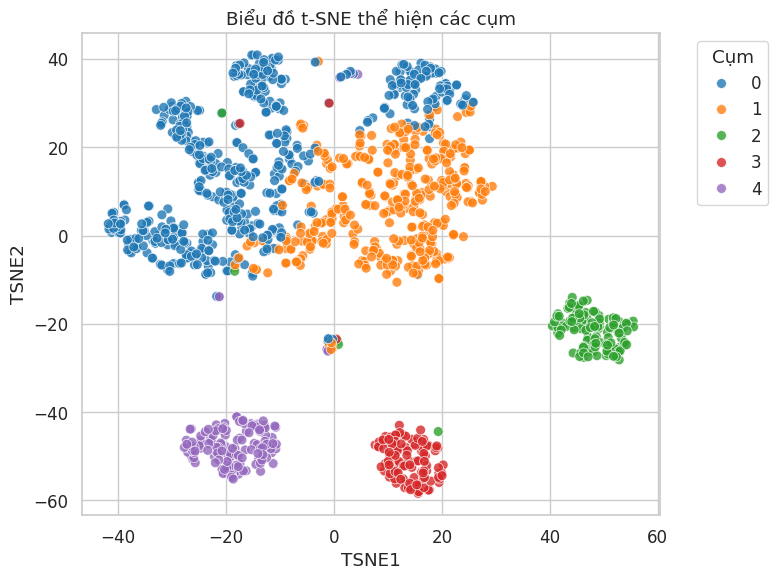

In [262]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cố định random để tái lập kết quả
np.random.seed(42)

# Tạo bản sao dữ liệu
X_plot = X.copy()

# Giảm chiều dữ liệu bằng T-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_plot[['TSNE1', 'TSNE2']] = tsne.fit_transform(X_scaled)

# Vẽ biểu đồ t-SNE
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=X_plot,
    x='TSNE1', y='TSNE2',
    hue='Label',
    palette='tab10',
    s=50,
    alpha=0.8
)
plt.title('Biểu đồ t-SNE thể hiện các cụm')
plt.legend(title='Cụm', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Boxplot so sánh các cụm theo từng biến**

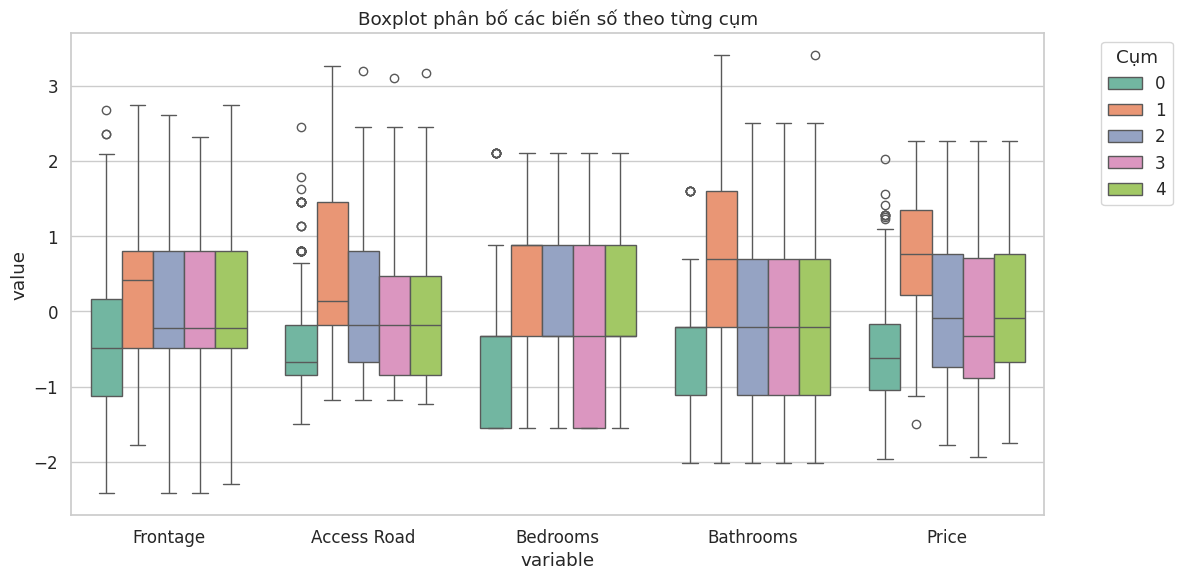

In [263]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
np.random.seed(42)

# Chuẩn bị dữ liệu dạng "long" để vẽ boxplot
melted = X_plot.melt(
    id_vars='Label',
    value_vars=[ 'Frontage', 'Access Road', 'Bedrooms', 'Bathrooms', 'Price']
)

# Vẽ Boxplot
plt.figure(figsize=(12,6))
sns.boxplot(data=melted, x='variable', y='value', hue='Label', palette='Set2')
plt.title('Boxplot phân bố các biến số theo từng cụm')
plt.legend(title='Cụm', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

**Heatmap trung bình các đặc trưng theo cụm**

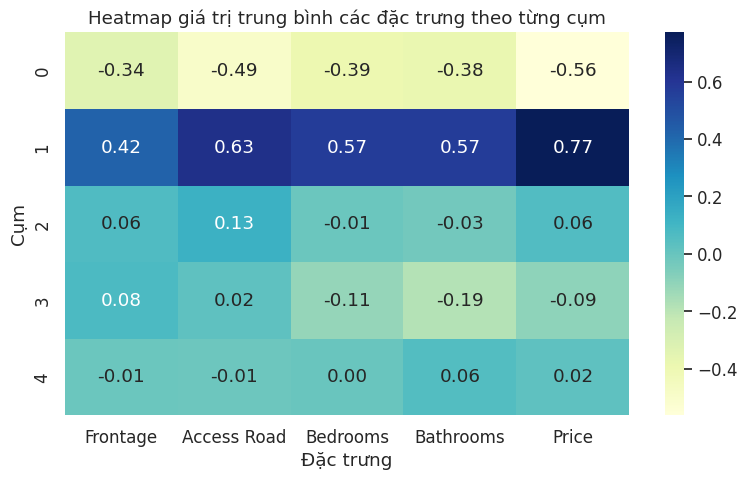

In [264]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tính trung bình theo cụm
cluster_means = X_plot.groupby('Label')[['Frontage', 'Access Road', 'Bedrooms', 'Bathrooms', 'Price']].mean()

# Vẽ Heatmap
plt.figure(figsize=(8,5))
sns.heatmap(cluster_means, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Heatmap giá trị trung bình các đặc trưng theo từng cụm')
plt.xlabel('Đặc trưng')
plt.ylabel('Cụm')
plt.tight_layout()
plt.show()

**Pairplot các biến chính**

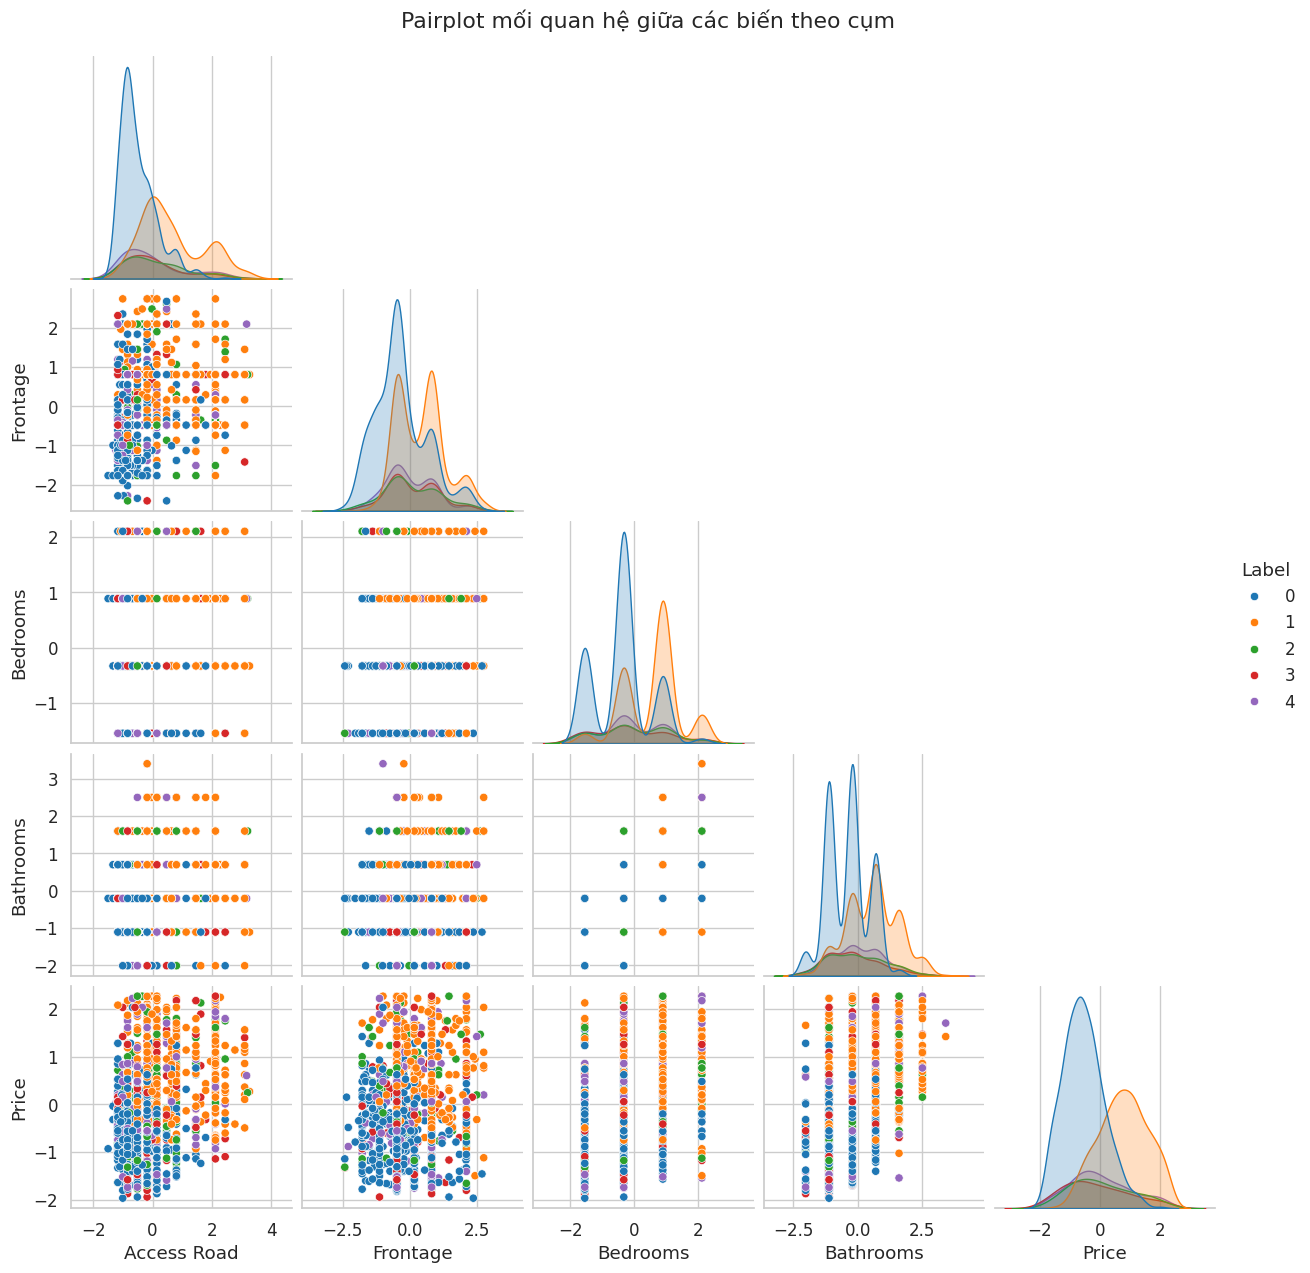

In [265]:
import seaborn as sns

# Chọn subset cột để vẽ 
subset_cols = ['Access Road', 'Frontage', 'Bedrooms', 'Bathrooms', 'Price', 'Label']

sns.pairplot(X_plot[subset_cols], hue='Label', palette='tab10', corner=True)
plt.suptitle('Pairplot mối quan hệ giữa các biến theo cụm', y=1.02)
plt.savefig("pairplot.png")
plt.show()

## DBSCAN

In [266]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [267]:
df = vietnam_housing_clean.copy()
if 'Access Road' in df.columns and 'Access_Road' not in df.columns:
    df = df.rename(columns={'Access Road':'Access_Road'})
if 'Access Road' in df.columns and 'Access_Road' not in df.columns:
    df.rename(columns={'Access Road':'Access_Road'}, inplace=True)

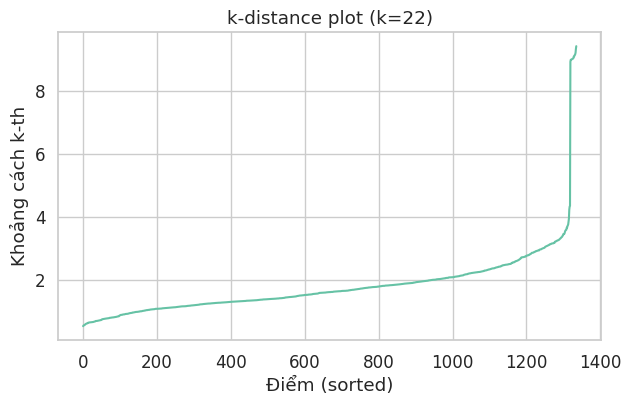

In [268]:
k = max(5, 2*X_scaled.shape[1])  # rule of thumb
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
dist, _ = nbrs.kneighbors(X_scaled)
kdist = np.sort(dist[:, -1])

plt.figure(figsize=(7,4))
plt.plot(kdist); plt.title(f'k-distance plot (k={k})')
plt.xlabel('Điểm (sorted)'); plt.ylabel('Khoảng cách k-th'); plt.show()


In [269]:
for eps_test in [1.2, 1.5, 1.8, 2.0, 2.3, 2.5]:
    db = DBSCAN(eps=eps_test, min_samples=10).fit(X)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise = (labels == -1).mean()
    print(f"eps={eps_test}: cụm={n_clusters}, noise={noise:.2%}")


eps=1.2: cụm=7, noise=45.28%
eps=1.5: cụm=6, noise=20.66%
eps=1.8: cụm=5, noise=7.63%
eps=2.0: cụm=3, noise=4.42%
eps=2.3: cụm=1, noise=0.82%
eps=2.5: cụm=1, noise=0.15%


In [270]:
# DBSCAN với eps = 1.5
db = DBSCAN(eps=1.5, min_samples=10).fit(X_scaled)
df['db'] = db.labels_

# K-Means để so sánh
km = KMeans(n_clusters=5, random_state=42).fit(X_scaled)
df['km'] = km.labels_

# Chỉ tính Silhouette nếu DBSCAN ra >=2 cụm khác nhau (bỏ noise -1)
mask = df['db'] != -1
n_clusters_db = len(set(df['db'][mask]))

if n_clusters_db > 1:
    print("Silhouette DBSCAN:", silhouette_score(X[mask], df['db'][mask]))
else:
    print("DBSCAN chỉ có 1 cụm hợp lệ → không tính được Silhouette")

print("Silhouette KMeans:", silhouette_score(X, df['km']))


Silhouette DBSCAN: 0.13722146403899305
Silhouette KMeans: 0.20928575888855544


**VISUALAZATION**

**Biểu đồ phân cụm 2D sau khi giảm chiều (PCA)**

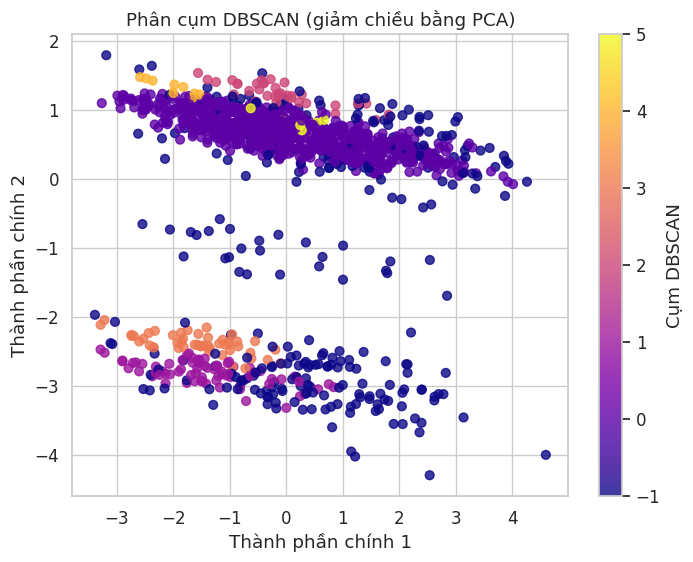

In [271]:
from sklearn.decomposition import PCA

# Giảm chiều dữ liệu để vẽ 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['db'], cmap='plasma', s=40, alpha=0.8)
plt.title('Phân cụm DBSCAN (giảm chiều bằng PCA)')
plt.xlabel('Thành phần chính 1')
plt.ylabel('Thành phần chính 2')
plt.colorbar(label='Cụm DBSCAN')
plt.show()

**So sánh DBSCAN và KMeans trên cùng mặt phẳng PCA**

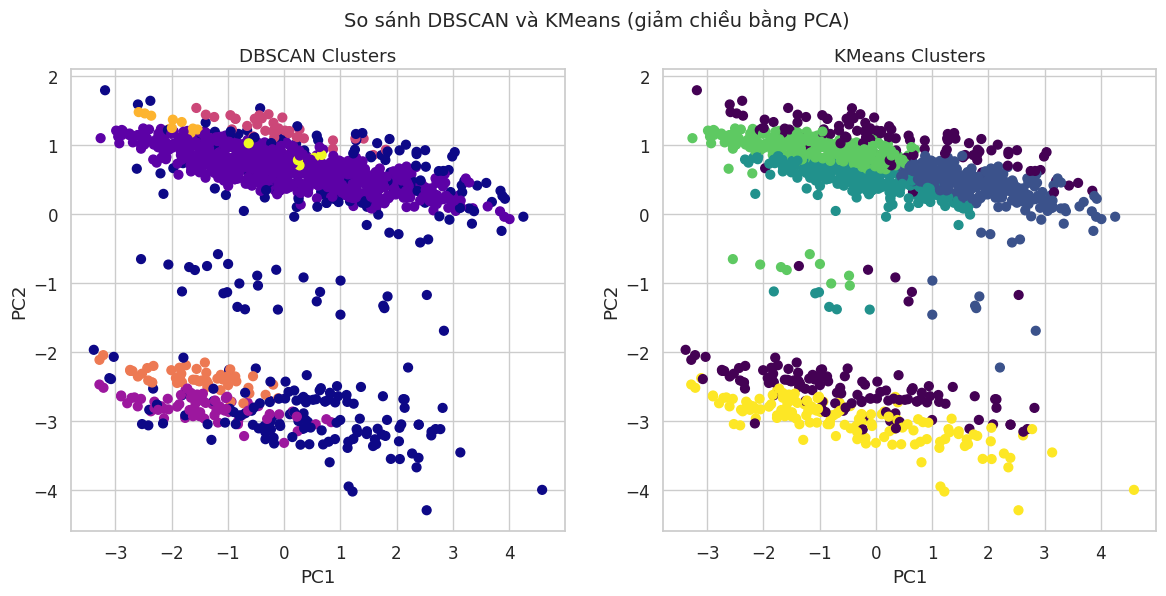

In [272]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

# DBSCAN
ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=df['db'], cmap='plasma', s=40)
ax[0].set_title('DBSCAN Clusters')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')

# KMeans
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], c=df['km'], cmap='viridis', s=40)
ax[1].set_title('KMeans Clusters')
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC2')

plt.suptitle('So sánh DBSCAN và KMeans (giảm chiều bằng PCA)', fontsize=14)
plt.show()

**Biểu đồ tần suất cụm DBSCAN**

/tmp/ipykernel_5573/3151818732.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='db', data=df, palette='plasma')


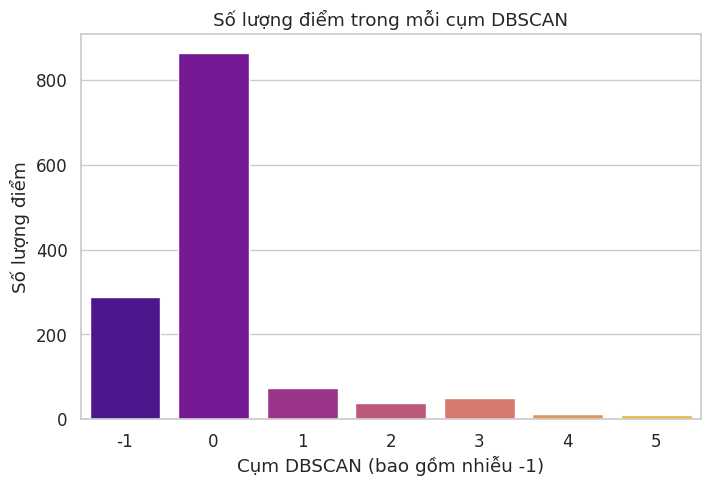

In [273]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x='db', data=df, palette='plasma')
plt.title('Số lượng điểm trong mỗi cụm DBSCAN')
plt.xlabel('Cụm DBSCAN (bao gồm nhiễu -1)')
plt.ylabel('Số lượng điểm')
plt.show()

**Trực quan hóa vùng nhiễu**

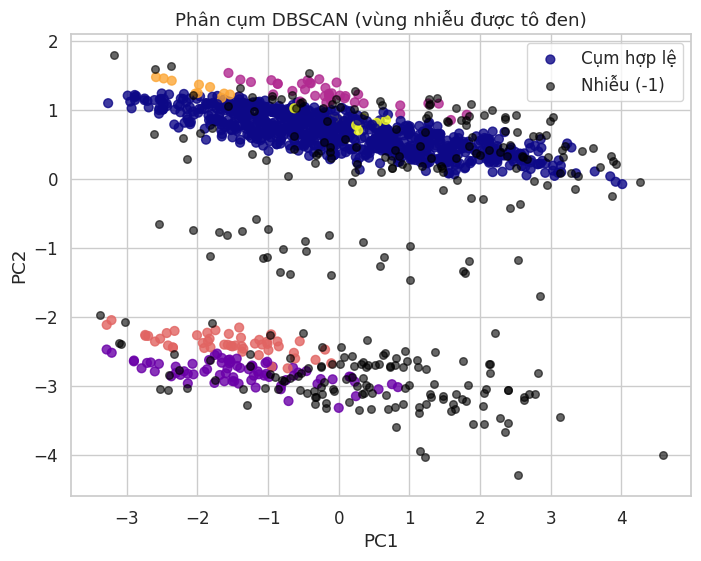

In [274]:
plt.figure(figsize=(8,6))
mask_noise = df['db'] == -1
plt.scatter(X_pca[~mask_noise, 0], X_pca[~mask_noise, 1], c=df['db'][~mask_noise], cmap='plasma', s=40, alpha=0.8, label='Cụm hợp lệ')
plt.scatter(X_pca[mask_noise, 0], X_pca[mask_noise, 1], c='black', s=30, alpha=0.6, label='Nhiễu (-1)')
plt.title('Phân cụm DBSCAN (vùng nhiễu được tô đen)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

## Hierarchical clustering 

In [275]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as pl

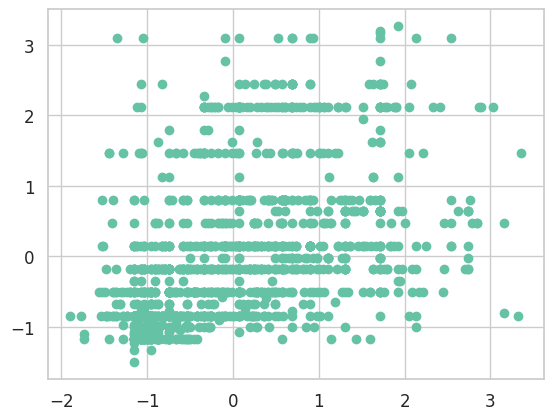

In [276]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline
# Generate a random cluster dataset to experiment on. 
# X = coordinate points, y = cluster labels (not needed)
X, y = make_blobs(n_samples=1000, centers=8, n_features=2,
random_state=800)
plt.scatter(X_scaled[:,0], X_scaled[:,1])
plt.show()

In [277]:
# Generate distance matrix with 'linkage' function
distances = linkage(X_scaled, method="centroid", metric="euclidean")
print(distances)

[[2.55000000e+02 1.22500000e+03 0.00000000e+00 2.00000000e+00]
 [2.57000000e+02 7.57000000e+02 0.00000000e+00 2.00000000e+00]
 [5.16000000e+02 1.12700000e+03 0.00000000e+00 2.00000000e+00]
 ...
 [2.66400000e+03 2.66500000e+03 4.83000855e+00 1.31800000e+03]
 [3.45000000e+02 2.66800000e+03 5.45389930e+00 1.31900000e+03]
 [2.66700000e+03 2.66900000e+03 9.07233442e+00 1.33600000e+03]]


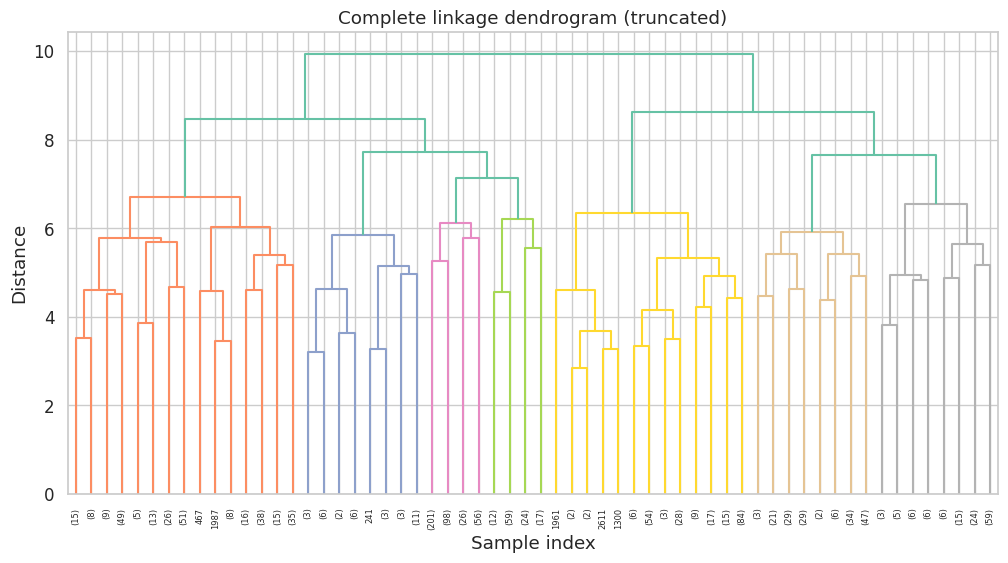

In [278]:
# select numeric columns only (or list the feature column names you want)
numeric_cols = vietnam_housing_clean.select_dtypes(include=[np.number]).columns.tolist()
X_hier = vietnam_housing_clean[numeric_cols].dropna()

if X_hier.shape[0] < 2 or X_hier.shape[1] < 1:
    raise ValueError("Not enough numeric rows/columns for hierarchical clustering. Check vietnam_housing_clean.")

# convert to numpy array (float) for linkage
X_vals = X_hier.values.astype(float)

complete_clustering = linkage(X_vals, method="complete", metric="euclidean")
average_clustering  = linkage(X_vals, method="average",  metric="euclidean")
single_clustering   = linkage(X_vals, method="single",   metric="euclidean")

# optional: plot a truncated dendrogram for the complete linkage
plt.figure(figsize=(12, 6))
dendrogram(complete_clustering, truncate_mode='level', p=5, labels=X_hier.index)
plt.title("Complete linkage dendrogram (truncated)")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

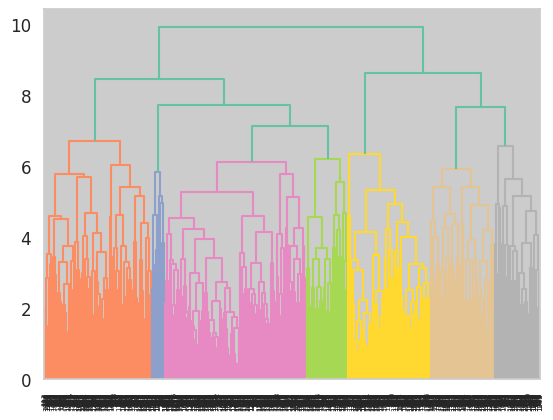

In [279]:
dendrogram(complete_clustering)
plt.show()

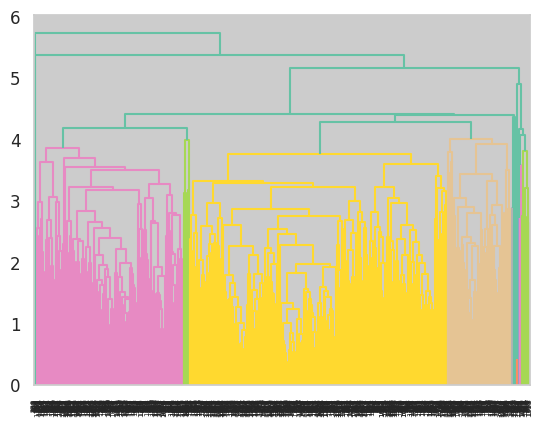

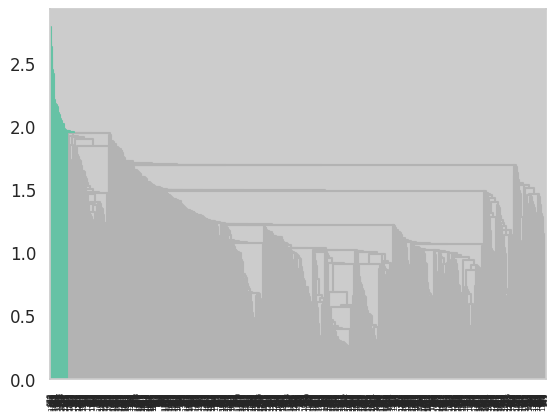

In [280]:
dendrogram(average_clustering)
plt.show()
dendrogram(single_clustering)
plt.show()

best_k=2, silhouette=0.1948


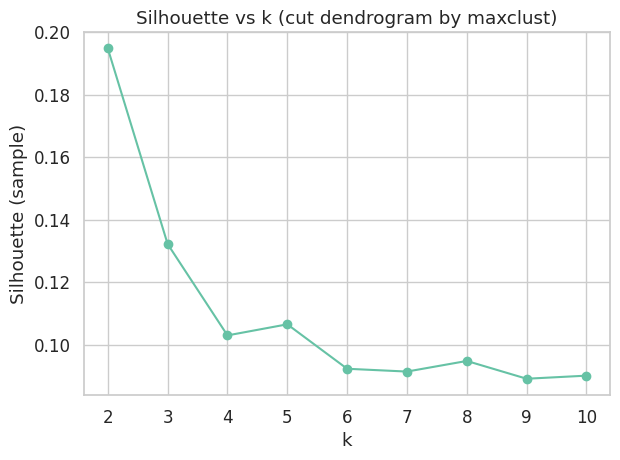

In [281]:
Z = complete_clustering 
# Giả sử `X_hier` là DataFrame
n = len(X_hier)

# Chọn một mẫu ngẫu nhiên (số điểm không quá 2000)
idx = np.random.default_rng(42).choice(n, size=min(2000, n), replace=False)

# Trích xuất mẫu ngẫu nhiên từ X_hier bằng iloc
X_s = X_hier.iloc[idx]  # Sử dụng iloc để trích xuất các hàng theo chỉ số

# Tạo dải giá trị k từ 2 đến 10
k_grid = range(2, 11)

# Tính silhouette score cho mỗi k
sil_scores = [silhouette_score(X_s, fcluster(Z, t=k, criterion="maxclust")[idx]) for k in k_grid]

# Lấy k tối ưu
best_k = list(k_grid)[int(np.nanargmax(sil_scores))]

# In ra kết quả
print(f"best_k={best_k}, silhouette={np.nanmax(sil_scores):.4f}")

# Vẽ đồ thị silhouette score theo k
import matplotlib.pyplot as plt
plt.plot(list(k_grid), sil_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette (sample)")
plt.title("Silhouette vs k (cut dendrogram by maxclust)")
plt.tight_layout()
plt.show()


In [282]:
labels_ser = pd.Series(labels, index=X_s.index, name="Cluster")
summary_rows = []
for c in sorted(np.unique(labels)):
    mask = (labels_ser.values == c)
    
    # Kiểm tra mask hợp lệ
    print(f"Cluster {c} - Mask shape: {mask.shape}, True count: {mask.sum()}")

    # Lấy median của các cột số trong X_s
    row = {"Cluster": int(c), "Count": int(mask.sum())}
    
    # Dùng iloc đúng cách (mask là mảng NumPy boolean)
    row.update(X_s.iloc[mask][numeric_cols].median().to_dict())
    
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows).sort_values("Cluster").reset_index(drop=True)

from IPython.display import display
display(summary_df)


Cluster -1 - Mask shape: (1336,), True count: 2
Cluster 0 - Mask shape: (1336,), True count: 1334


Cluster  Count      Area  Frontage  Access Road  Floors  Bedrooms  \
0       -1      2 -0.528306 -1.126738    -0.348129     2.5  -0.33217   
1        0   1334 -0.171136 -0.353364    -0.183858     3.0  -0.33217   

   Bathrooms     Price  House_direction_sin  House_direction_cos  \
0  -0.208783  0.262889                  0.0                  1.0   
1  -0.208783 -0.138523                  0.0                  1.0   

   Balcony_direction_sin  Balcony_direction_cos  
0                    0.0                    1.0  
1                    0.0                    1.0

/tmp/ipykernel_5573/3459741769.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y=target, data=df_cluster, palette="Set2")


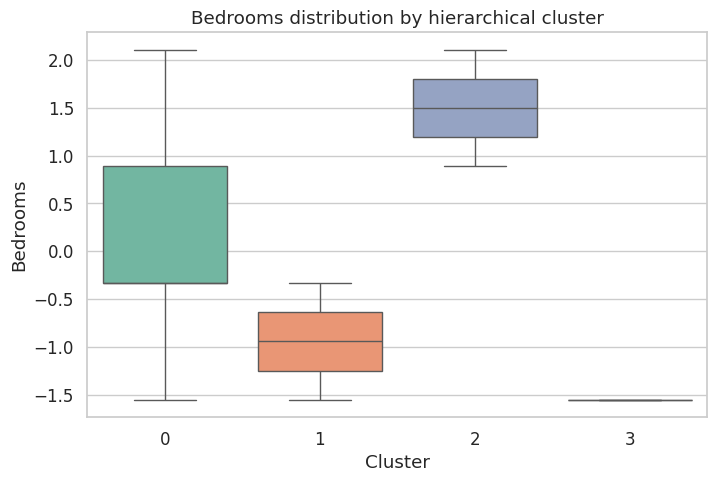

In [283]:
from scipy.cluster.hierarchy import cut_tree
import seaborn as sns
import matplotlib.pyplot as plt
# Cắt cây dendrogram thành 2 cụm (đổi số nếu muốn)
cluster_labels = cut_tree(average_clustering, n_clusters=4).reshape(-1, )

# Gắn nhãn cụm vào dataframe đang dùng (X_hier hoặc vietnam_housing_scaled)
df_cluster = X_hier.copy()
df_cluster["Cluster"] = cluster_labels

# Chọn biến để xem ý nghĩa (ví dụ 'Price')
target = "Bedrooms"

# Vẽ boxplot để so sánh phân bố biến theo cụm
plt.figure(figsize=(8,5))
sns.boxplot(x="Cluster", y=target, data=df_cluster, palette="Set2")
plt.title(f"{target} distribution by hierarchical cluster")
plt.show()

In [284]:
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score
# 1. Chuẩn hóa
X = vietnam_housing_clean[num_cols].dropna()
X_scaled = StandardScaler().fit_transform(X)
# 2. Linkage
Z = linkage(X_scaled, method='ward')
# 3. Cắt cụm (ví dụ 4 cụm)
labels = fcluster(Z, t=2, criterion='maxclust')
# 4. Silhouette Score
sil_score = silhouette_score(X_scaled, labels)
print("✅ Silhouette Score:", sil_score)

✅ Silhouette Score: 0.2878148930031892


✅ Best k (Ward linkage) = 3, Silhouette = 0.3238


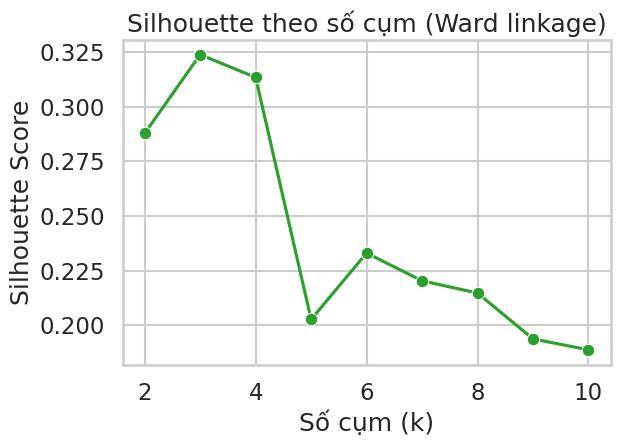

In [285]:
# Ward linkage
Z = linkage(X_scaled, method='ward')

# Lấy mẫu ngẫu nhiên tối đa 2000 điểm
n = len(X_scaled)
idx = np.random.default_rng(42).choice(n, size=min(2000, n), replace=False)
X_s = X_scaled[idx]

# Tính silhouette cho từng k
k_grid = range(2, 11)
sil_scores = [silhouette_score(X_s, fcluster(Z, t=k, criterion="maxclust")[idx]) for k in k_grid]

# Xác định k tối ưu
best_k = list(k_grid)[int(np.nanargmax(sil_scores))]
print(f"✅ Best k (Ward linkage) = {best_k}, Silhouette = {np.nanmax(sil_scores):.4f}")

# Vẽ biểu đồ
sns.set(style="whitegrid", context="talk")
sns.lineplot(x=list(k_grid), y=sil_scores, marker='o', color="#2ca02c")
plt.title("Silhouette theo số cụm (Ward linkage)")
plt.xlabel("Số cụm (k)")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()


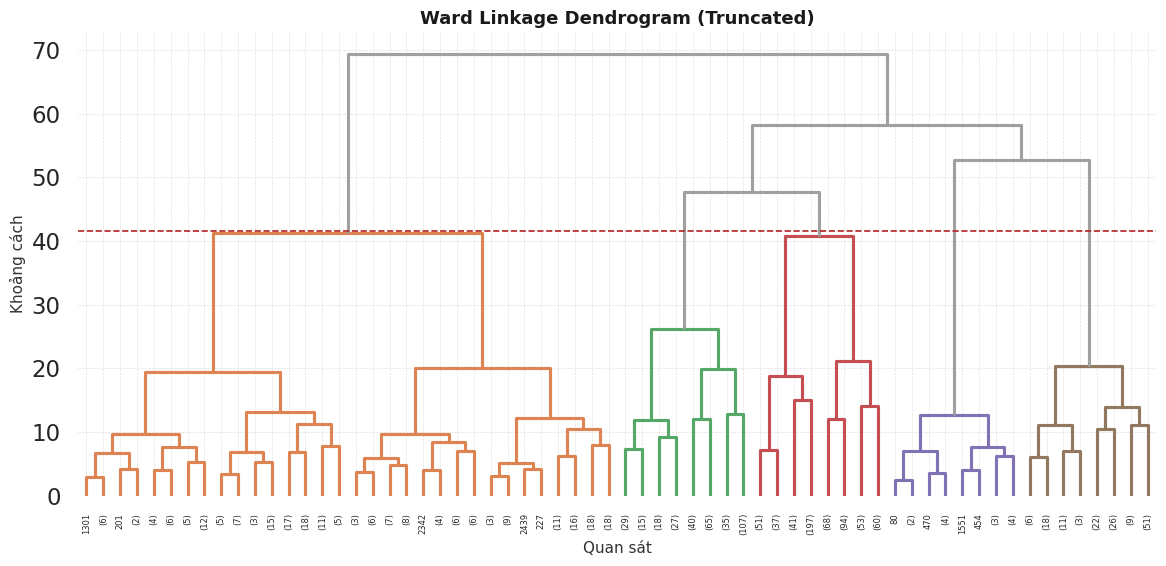

In [286]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6), facecolor='white')

# Dendrogram Ward linkage (rút gọn)
dendrogram(
    Z,
    truncate_mode='level',
    p=5,
    labels=X_hier.index,
    color_threshold=0.6 * max(Z[:, 2]),
    above_threshold_color="#A0A0A0"
)

# Tiêu đề & nhãn
plt.title("Ward Linkage Dendrogram (Truncated)", fontsize=13, fontweight='bold', color='#1A1A1A')
plt.xlabel("Quan sát", fontsize=11, color="#333333")
plt.ylabel("Khoảng cách", fontsize=11, color="#333333")

# Đường cắt cụm đỏ
plt.axhline(y=0.6 * max(Z[:, 2]), color="#B22222", linestyle="--", linewidth=1.2)

# Lưới nhẹ & nền trắng
plt.grid(True, linestyle='--', linewidth=0.5, color="#E0E0E0")
plt.gca().set_facecolor('white')
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()


In [287]:
for k in range(2, 7):
    labels_hier = fcluster(Z, t=k, criterion='maxclust')
    silhouette = silhouette_score(X_scaled, labels_hier)
    print(f"Silhouette Score for k={k}: {silhouette:.4f}")


Silhouette Score for k=2: 0.2878
Silhouette Score for k=3: 0.3238
Silhouette Score for k=4: 0.3133
Silhouette Score for k=5: 0.2026
Silhouette Score for k=6: 0.2330


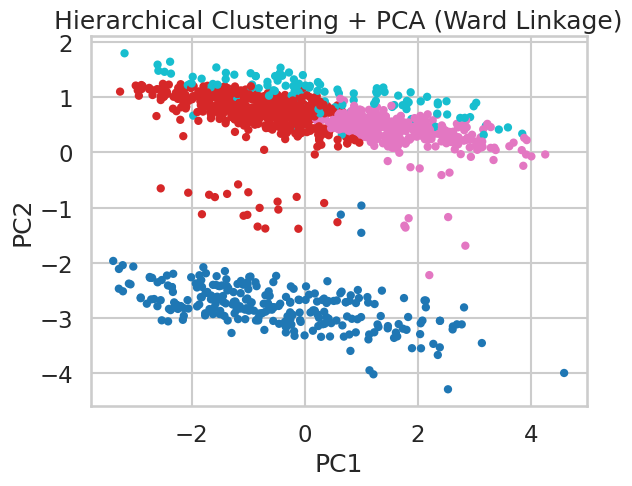

In [288]:
from sklearn.decomposition import PCA

# Chọn số lượng thành phần PCA nhỏ hơn hoặc bằng số đặc trưng trong dữ liệu (ở đây là 5)
pca = PCA(n_components=3)  # Hoặc có thể chọn n_components=2 để giảm xuống 2 chiều
X_reduced = pca.fit_transform(X_scaled)

# Tiến hành phân cụm với dữ liệu giảm chiều
Z = linkage(X_reduced, method='ward')

# Cắt cụm với số cụm tùy chọn
labels_hier = fcluster(Z, t=4, criterion='maxclust')

# Hiển thị kết quả trực quan
pca = PCA(n_components=2)  # Giảm xuống 2 chiều để trực quan hóa
X_pca = pca.fit_transform(X_scaled)

# Vẽ scatter plot với các cụm khác nhau
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_hier, cmap='tab10', s=20)
plt.title("Hierarchical Clustering + PCA (Ward Linkage)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()



In [289]:

# Cắt cây phân cụm theo k tối ưu (Ward linkage)
labels = fcluster(Z, t=best_k, criterion='maxclust')

# Kiểm tra số cụm và phân bố
print(f"Số cụm được hình thành (Ward): {len(np.unique(labels))}")
print("Phân bố số lượng quan sát trong từng cụm:", np.unique(labels, return_counts=True))



Số cụm được hình thành (Ward): 3
Phân bố số lượng quan sát trong từng cụm: (array([1, 2, 3], dtype=int32), array([256, 598, 482]))


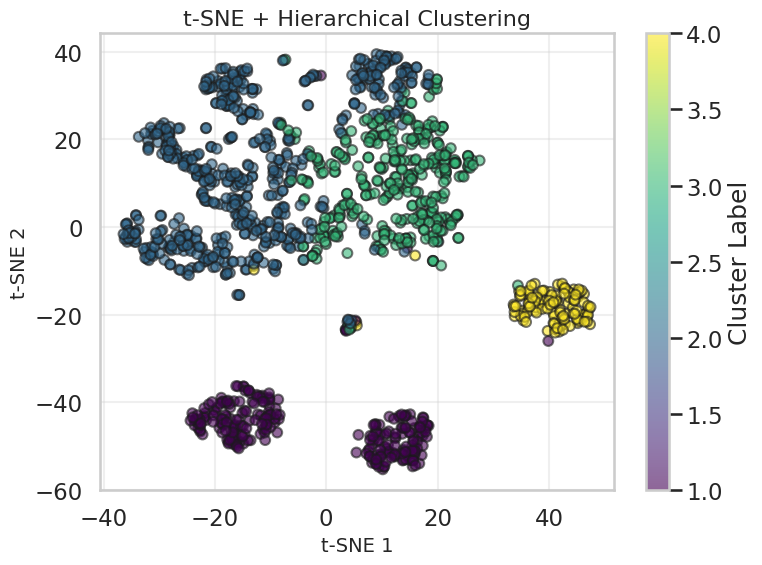

In [290]:
from sklearn.manifold import TSNE

# Áp dụng t-SNE để giảm chiều xuống 2D
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Vẽ scatter plot sau khi giảm chiều bằng t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_hier, cmap='viridis', s=50, alpha=0.6, edgecolors='k')
plt.title("t-SNE + Hierarchical Clustering", fontsize=16)
plt.xlabel("t-SNE 1", fontsize=14)
plt.ylabel("t-SNE 2", fontsize=14)
plt.colorbar(label='Cluster Label')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


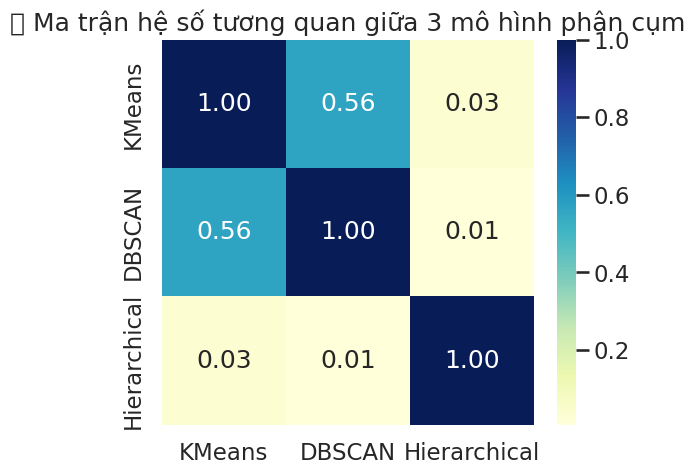

✅ Ma trận tương quan giữa các phương pháp phân cụm:


KMeans    DBSCAN  Hierarchical
KMeans        1.000000  0.562342      0.031600
DBSCAN        0.562342  1.000000      0.007896
Hierarchical  0.031600  0.007896      1.000000

In [291]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Giả sử các nhãn đã có:
# df['km'] – KMeans
# df['db'] – DBSCAN
# df_cluster['Cluster'] – Hierarchical

# 1️⃣ Gộp nhãn lại thành một DataFrame chung
compare_df = pd.DataFrame({
    'KMeans': df['km'].values,
    'DBSCAN': df['db'].values,
    'Hierarchical': df_cluster['Cluster'].reindex(df.index, fill_value=-1).values
})

# 2️⃣ Đảm bảo các giá trị đều là số (tránh lỗi khi tính)
for col in compare_df.columns:
    le = LabelEncoder()
    compare_df[col] = le.fit_transform(compare_df[col])

# 3️⃣ Hàm tính Cramér’s V giữa hai phân cụm
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# 4️⃣ Tạo ma trận hệ số tương quan
methods = ['KMeans', 'DBSCAN', 'Hierarchical']
coef_matrix = pd.DataFrame(index=methods, columns=methods, dtype=float)

for i in methods:
    for j in methods:
        coef_matrix.loc[i, j] = cramers_v(compare_df[i], compare_df[j])

# 5️⃣ Hiển thị ma trận
plt.figure(figsize=(6,5))
sns.heatmap(coef_matrix.astype(float), annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("🔹 Ma trận hệ số tương quan giữa 3 mô hình phân cụm")
plt.show()

# 6️⃣ In kết quả chi tiết
print("✅ Ma trận tương quan giữa các phương pháp phân cụm:")
display(coef_matrix)


In [292]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# Giả sử các nhãn đã có
labels_km = df['km']
labels_db = df['db']
labels_hier = df_cluster['Cluster'].reindex(df.index, fill_value=-1)  # 🔁 đồng bộ index

# Loại bỏ noise trong DBSCAN
mask = labels_db != -1

# Lọc 3 nhãn theo mask (sử dụng .loc để tránh lỗi index)
labels_db_clean = labels_db.loc[mask]
labels_km_clean = labels_km.loc[mask]
labels_hier_clean = labels_hier.loc[mask]

# ✅ Tính ARI và AMI
compare_metrics = pd.DataFrame({
    "Model Comparison": [
        "KMeans vs DBSCAN",
        "KMeans vs Hierarchical",
        "DBSCAN vs Hierarchical"
    ],
    "ARI": [
        adjusted_rand_score(labels_km_clean, labels_db_clean),
        adjusted_rand_score(labels_km, labels_hier),
        adjusted_rand_score(labels_db_clean, labels_hier_clean)
    ],
    "AMI": [
        adjusted_mutual_info_score(labels_km_clean, labels_db_clean),
        adjusted_mutual_info_score(labels_km, labels_hier),
        adjusted_mutual_info_score(labels_db_clean, labels_hier_clean)
    ]
})
print(compare_metrics)



         Model Comparison       ARI       AMI
0        KMeans vs DBSCAN  0.240380  0.529953
1  KMeans vs Hierarchical  0.000576  0.001242
2  DBSCAN vs Hierarchical  0.000000  0.000000


**VISUALIZATION**

**Phân bố cụm (Scatter Plot)**

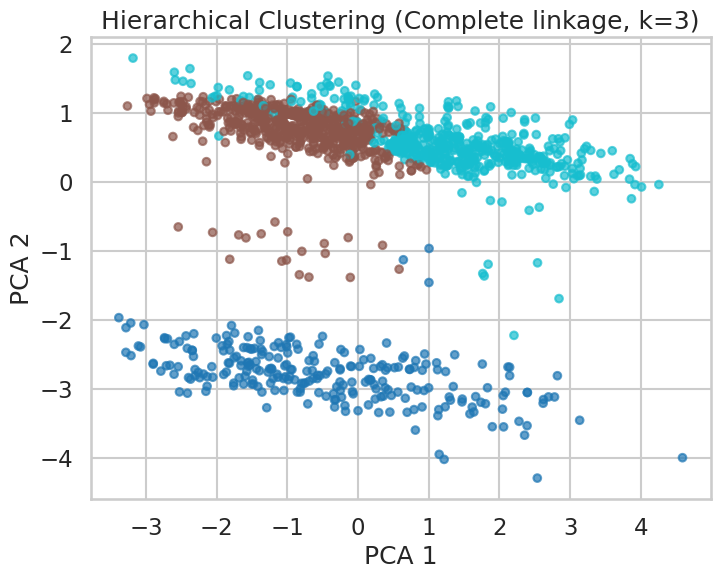

In [293]:
from sklearn.decomposition import PCA

# Giảm về 2 chiều để vẽ
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_s)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels[idx], cmap='tab10', s=30, alpha=0.7)
plt.title(f"Hierarchical Clustering (Complete linkage, k={best_k})")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

**Boxplot mô tả đặc trưng từng cụm**

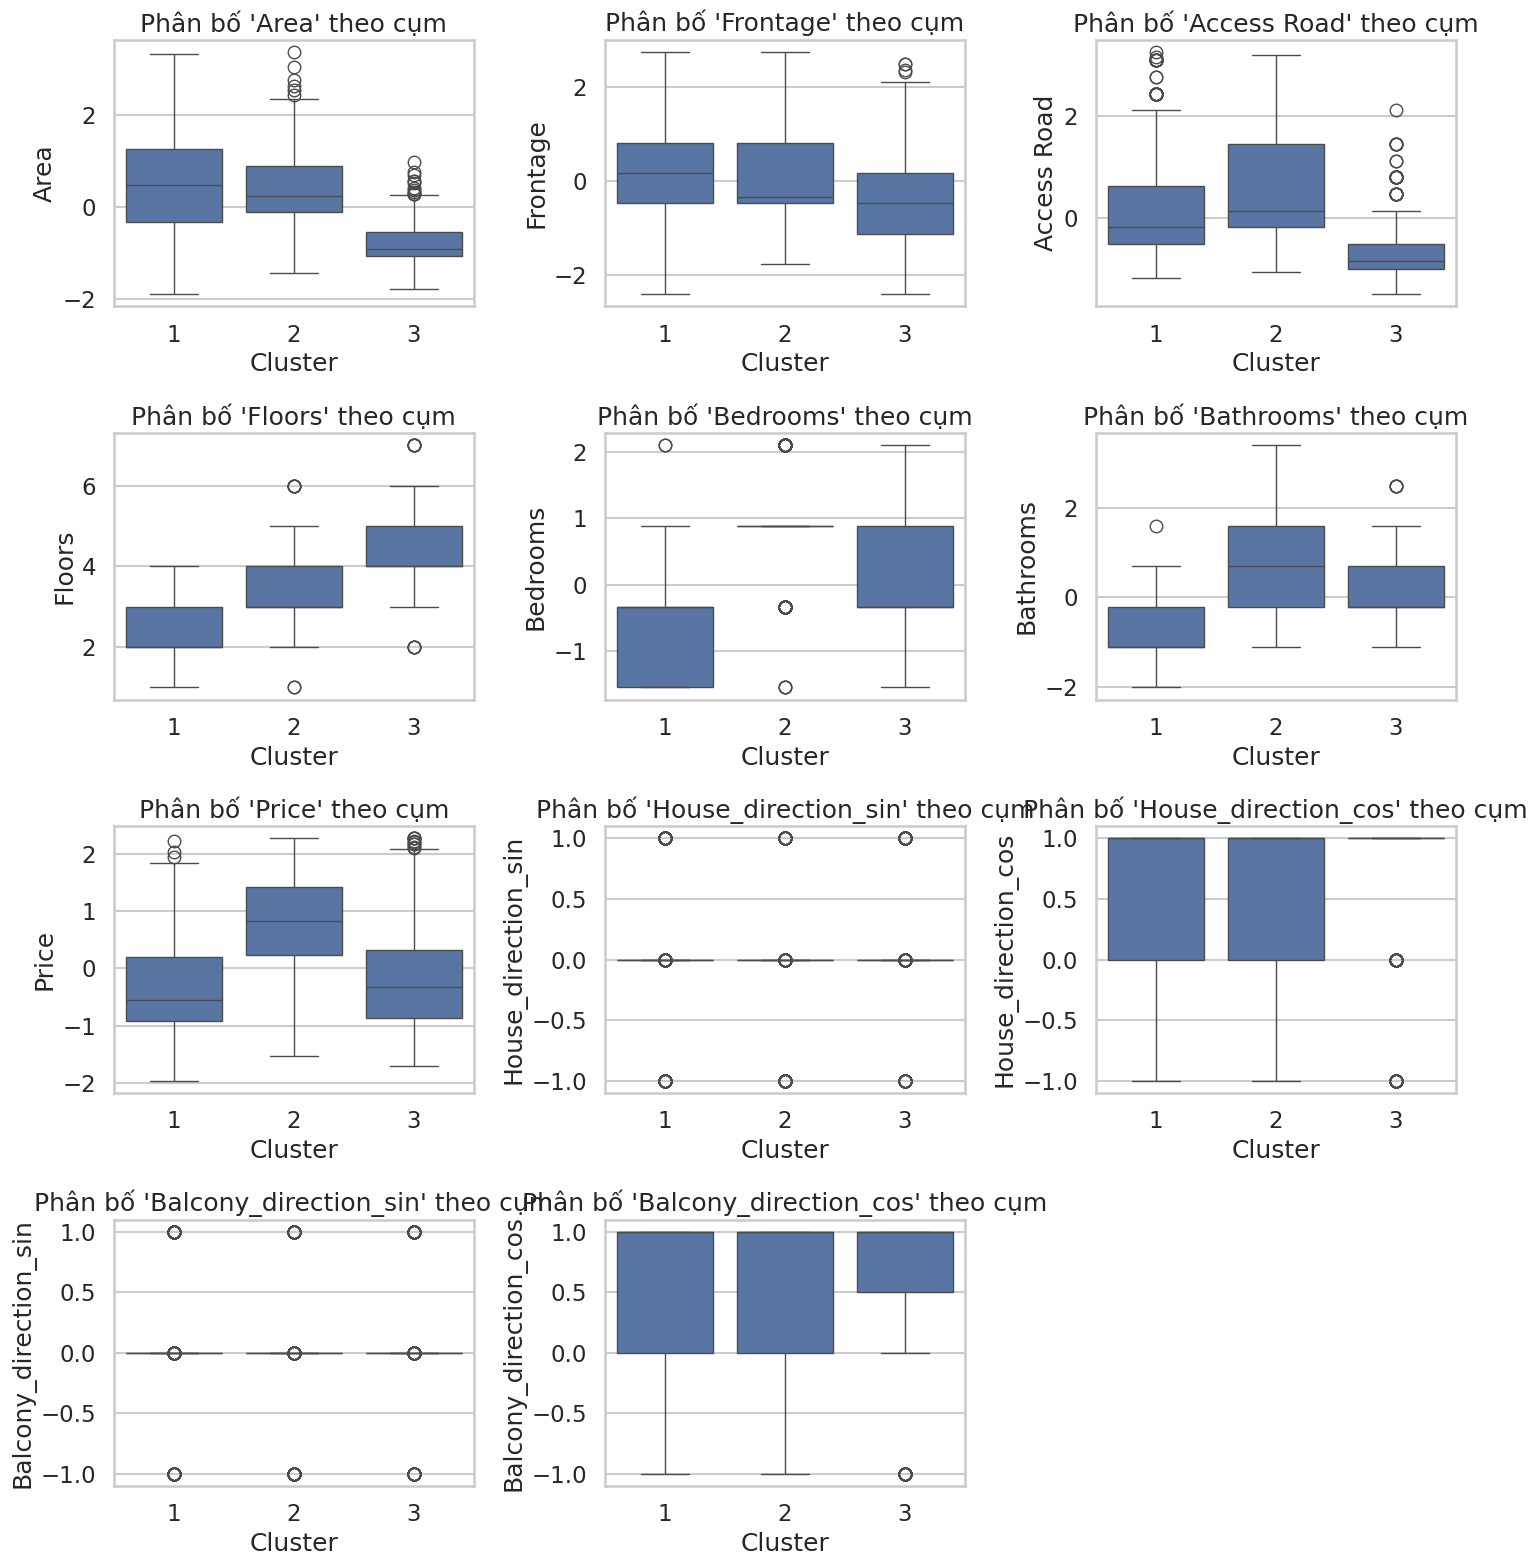

In [294]:

from scipy.cluster.hierarchy import linkage, fcluster

Z = linkage(X_hier, method='ward')  

# Sau đó gán nhãn cụm
clustered = X_hier.copy()
clustered['Cluster'] = fcluster(Z, t=3, criterion='maxclust')  

# Vẽ boxplot cho tất cả các biến (trừ Cluster)
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = [col for col in clustered.columns if col != 'Cluster']

n_cols = 3
n_rows = -(-len(numeric_cols) // n_cols)
plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=clustered, x='Cluster', y=col)
    plt.title(f"Phân bố '{col}' theo cụm")

plt.tight_layout()
plt.show()


**Heatmap trung vị đặc trưng cụm**

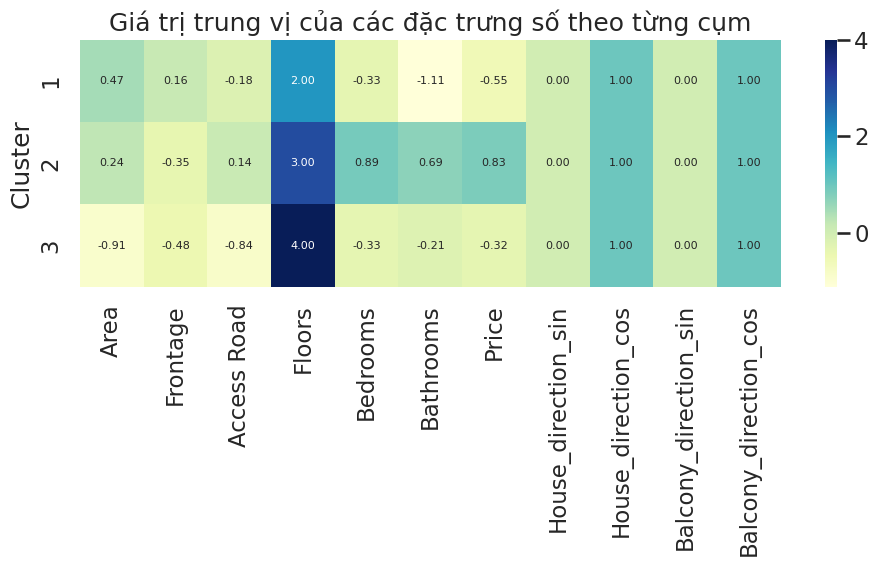

In [320]:
summary = clustered.groupby('Cluster')[numeric_cols].median()

plt.figure(figsize=(10, 6))
sns.heatmap(
    summary,
    cmap='YlGnBu',
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8}   # giảm kích thước chữ (mặc định khoảng 10–12)
)
plt.title("Giá trị trung vị của các đặc trưng số theo từng cụm")
plt.tight_layout()  # giúp bố cục gọn gàng, tránh tràn chữ
plt.show()


**Biểu đồ Silhouette cho từng điểm**

✅ Silhouette Score (k=3): 0.1898


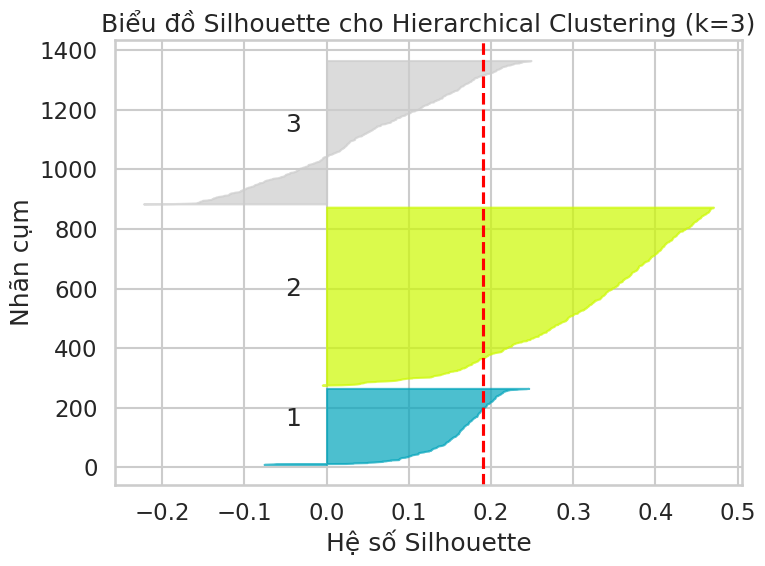

In [296]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

# Tính hệ số Silhouette cho từng điểm
silhouette_vals = silhouette_samples(X_scaled, labels)
silhouette_avg = silhouette_score(X_scaled, labels)
print(f"✅ Silhouette Score (k=3): {silhouette_avg:.4f}")

# Vẽ biểu đồ silhouette
plt.figure(figsize=(8, 6))
y_lower = 10
for i in range(1, 4):  # vì có 3 cụm
    ith_cluster_silhouette_values = silhouette_vals[labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / 3)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # khoảng cách giữa cụm

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title("Biểu đồ Silhouette cho Hierarchical Clustering (k=3)")
plt.xlabel("Hệ số Silhouette")
plt.ylabel("Nhãn cụm")
plt.tight_layout()
plt.show()


classification mới

1. Import

In [297]:
# === IMPORT ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, RocCurveDisplay, silhouette_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

2. Tiền xử lý dữ liệu

In [298]:

X_train = vietnam_housing_clean[
    ['Area', 'Bedrooms', 'Bathrooms', 'Frontage',
     'House_direction_sin', 'House_direction_cos',
     'Balcony_direction_sin', 'Balcony_direction_cos',
     'Legal_status_1', 'Furniture_state_1']
]

X_test = vietnam_housing_test_clean[
    ['Area', 'Bedrooms', 'Bathrooms', 'Frontage',
     'House_direction_sin', 'House_direction_cos',
     'Balcony_direction_sin', 'Balcony_direction_cos',
     'Legal_status_1', 'Furniture_state_1']
]

In [299]:
# Lấy cột nhãn (target column) riêng biệt
y_train = vietnam_housing_clean['Price']  # Cột nhãn mục tiêu trong dữ liệu huấn luyện
y_test = vietnam_housing_test['Price']

In [300]:
# LẤY y TỪ CÙNG *_clean* VÀ CĂN THEO INDEX CỦA X
y_train_cont = vietnam_housing_clean.loc[X_train.index, 'Price'].copy()
y_test_cont  = vietnam_housing_test_clean.loc[X_test.index,  'Price'].copy()

# (Nếu còn NA) drop đồng bộ theo (X,y)
mask_tr = (~X_train.isna().any(axis=1)) & (~y_train_cont.isna())
mask_te = (~X_test.isna().any(axis=1))  & (~y_test_cont.isna())
X_train, y_train_cont = X_train.loc[mask_tr], y_train_cont.loc[mask_tr]
X_test,  y_test_cont  = X_test.loc[mask_te],  y_test_cont.loc[mask_te]


In [301]:
import numpy as np

thr = float(np.median(y_train_cont))   # hoặc np.mean(...)
y_train_cls = (y_train_cont >= thr).map({False: f"Low(<{thr:.0f})",
                                         True:  f"High(≥{thr:.0f})"}).astype('category')
y_test_cls  = (y_test_cont  >= thr).map({False: f"Low(<{thr:.0f})",
                                         True:  f"High(≥{thr:.0f})"}).astype('category')

print("X_train:", X_train.shape, "| y_train_cls:", y_train_cls.shape)
print("X_test :", X_test.shape,  "| y_test_cls :", y_test_cls.shape)

X_train: (1336, 10) | y_train_cls: (1336,)
X_test : (666, 10) | y_test_cls : (666,)


In [302]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, RocCurveDisplay
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

3. Đánh gía mô hình

In [303]:
def evaluate(model, Xtr, ytr, Xte, yte, title):
    yhat_tr = model.predict(Xtr)
    yhat_te = model.predict(Xte)
    print(f"\n=== {title} ===")
    print(f"Accuracy (train): {accuracy_score(ytr, yhat_tr):.4f}")
    print(f"Accuracy (test) : {accuracy_score(yte, yhat_te):.4f}")
    print(classification_report(yte, yhat_te))

    # Confusion matrix
    cm, labels = confusion_matrix(yte, yhat_te), np.unique(yte)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"{title} — Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks(range(len(labels)), labels, rotation=45)
    plt.yticks(range(len(labels)), labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i,j], ha="center", va="center")
    plt.tight_layout(); plt.show()

    # ROC-AUC nếu nhị phân
    if len(labels) == 2 and hasattr(model, "predict_proba"):
        proba = model.predict_proba(Xte)[:, 1]
        y_true_bin = (yte == labels[1]).astype(int)
        auc = roc_auc_score(y_true_bin, proba)
        print(f"ROC-AUC (test): {auc:.4f}")
        RocCurveDisplay.from_predictions(y_true_bin, proba)
        plt.title(f"{title} — ROC Curve")
        plt.show()

4.GridSearchCV

In [304]:
def run_models(specs, Xtr, ytr, Xte, yte, scoring="accuracy", cv_splits=5):
    rows, out = [], {}
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    for name, s in specs.items():
        steps = []
        if s.get("scale", False):
            steps.append(("scaler", StandardScaler()))
        steps.append(("clf", s["est"]))
        pipe = Pipeline(steps)

        gs = GridSearchCV(
            pipe, s["grid"], scoring=scoring,
            cv=cv, n_jobs=-1, refit=True, verbose=0
        )
        gs.fit(Xtr, ytr)

        best = gs.best_estimator_
        out[name] = {"best": best, "params": gs.best_params_}
        rows.append({
            "Model": name,
            "Best Params": gs.best_params_,
            "Test Accuracy": accuracy_score(yte, best.predict(Xte))
        })
        evaluate(best, Xtr, ytr, Xte, yte, name)

    summary = pd.DataFrame(rows).sort_values("Test Accuracy", ascending=False).reset_index(drop=True)
    return out, summary

5.Khai báo tham số

In [305]:
model_specs = {
    "Logistic Regression": {
        "est": LogisticRegression(max_iter=2000),
        "scale": True,
        "grid": {
            "clf__C": [0.01, 0.1, 1, 10],
            "clf__penalty": ["l2"],
            "clf__solver": ["lbfgs", "liblinear"]
        }
    },
    "Decision Tree": {
        "est": DecisionTreeClassifier(random_state=42),
        "scale": False,
        "grid": {
            "clf__criterion": ["gini", "entropy"],
            "clf__max_depth": [None, 3, 5, 8, 12],
            "clf__min_samples_split": [2, 5, 10],
            "clf__min_samples_leaf": [1, 2, 5]
        }
    },
    "Random Forest": {
        "est": RandomForestClassifier(random_state=42, n_jobs=-1),
        "scale": False,
        "grid": {
            "clf__n_estimators": [100, 300],
            "clf__max_depth": [None, 8, 12],
            "clf__max_features": ["sqrt", "log2"],
            "clf__min_samples_leaf": [1, 2, 5]
        }
    }
}

6.Chạy huấn luyện


=== Logistic Regression ===
Accuracy (train): 0.7058
Accuracy (test) : 0.6832
              precision    recall  f1-score   support

   High(≥-0)       0.71      0.65      0.68       344
    Low(<-0)       0.66      0.72      0.69       322

    accuracy                           0.68       666
   macro avg       0.69      0.68      0.68       666
weighted avg       0.69      0.68      0.68       666



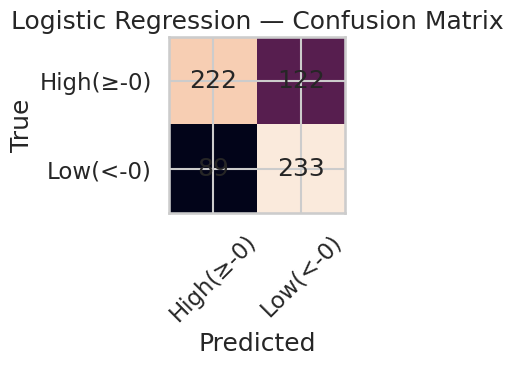

ROC-AUC (test): 0.7489


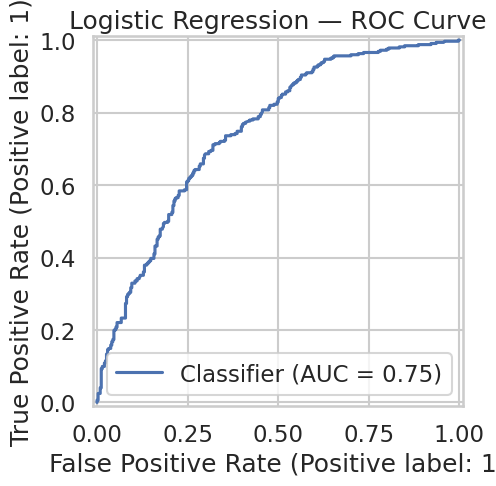


=== Decision Tree ===
Accuracy (train): 0.7260
Accuracy (test) : 0.6967
              precision    recall  f1-score   support

   High(≥-0)       0.77      0.59      0.67       344
    Low(<-0)       0.65      0.81      0.72       322

    accuracy                           0.70       666
   macro avg       0.71      0.70      0.69       666
weighted avg       0.71      0.70      0.69       666



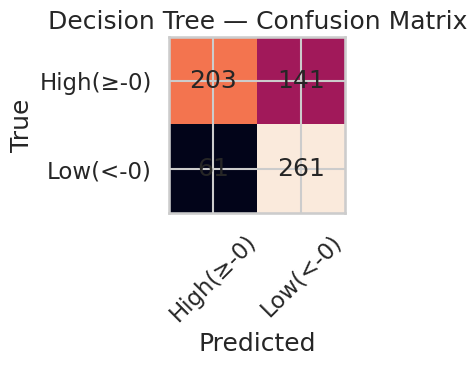

ROC-AUC (test): 0.7201


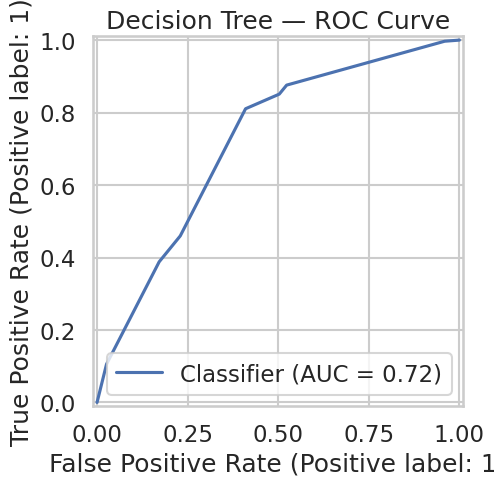


=== Random Forest ===
Accuracy (train): 0.7807
Accuracy (test) : 0.6997
              precision    recall  f1-score   support

   High(≥-0)       0.76      0.62      0.68       344
    Low(<-0)       0.66      0.79      0.72       322

    accuracy                           0.70       666
   macro avg       0.71      0.70      0.70       666
weighted avg       0.71      0.70      0.70       666



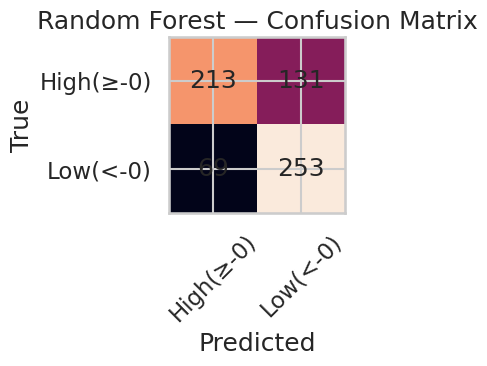

ROC-AUC (test): 0.7589


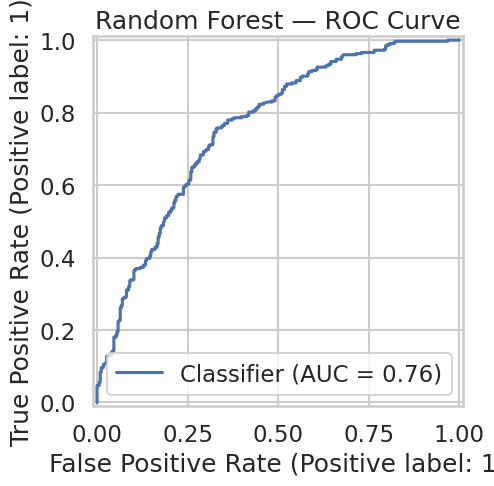

Model                                        Best Params  \
0        Random Forest  {'clf__max_depth': 8, 'clf__max_features': 'sq...   
1        Decision Tree  {'clf__criterion': 'entropy', 'clf__max_depth'...   
2  Logistic Regression  {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solv...   

   Test Accuracy  
0       0.699700  
1       0.696697  
2       0.683183

In [306]:

out, summary = run_models(
    model_specs,
    X_train, y_train_cls,
    X_test, y_test_cls,
    scoring="accuracy",
    cv_splits=5
)

summary



7.Vẽ biểu đồ so sánh độ chính xác

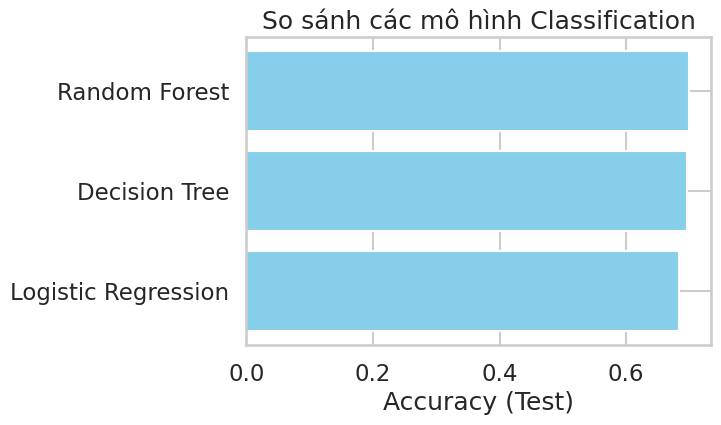

In [307]:
plt.figure(figsize=(6,4))
plt.barh(summary['Model'], summary['Test Accuracy'], color='skyblue')
plt.xlabel('Accuracy (Test)')
plt.title('So sánh các mô hình Classification')
plt.gca().invert_yaxis()
plt.show()

## VISUALIZATION FOR LOGISTIC REGRESSION


🔹 Biểu đồ phân tích mô hình: Logistic Regression


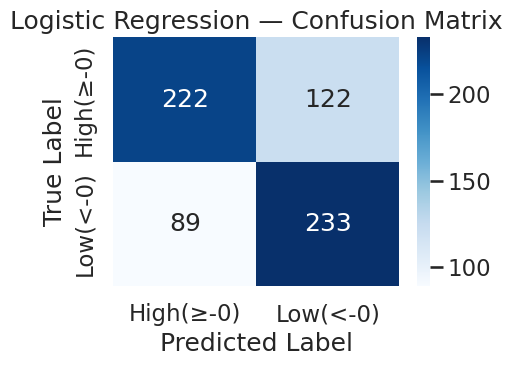

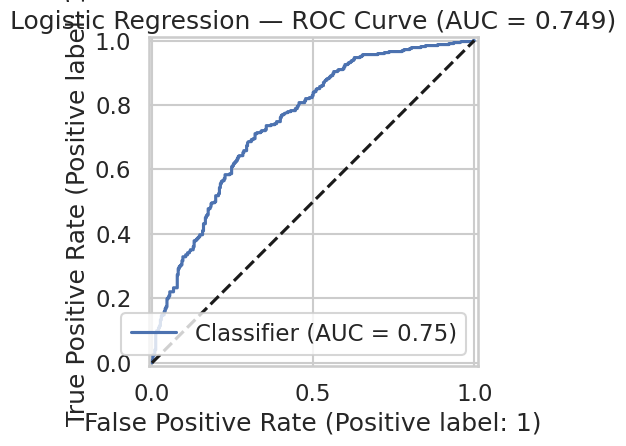

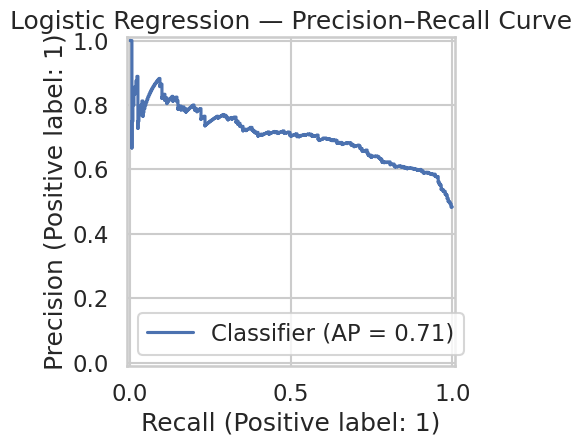

/tmp/ipykernel_5573/3459397800.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Coefficient", y="Feature", palette="coolwarm")


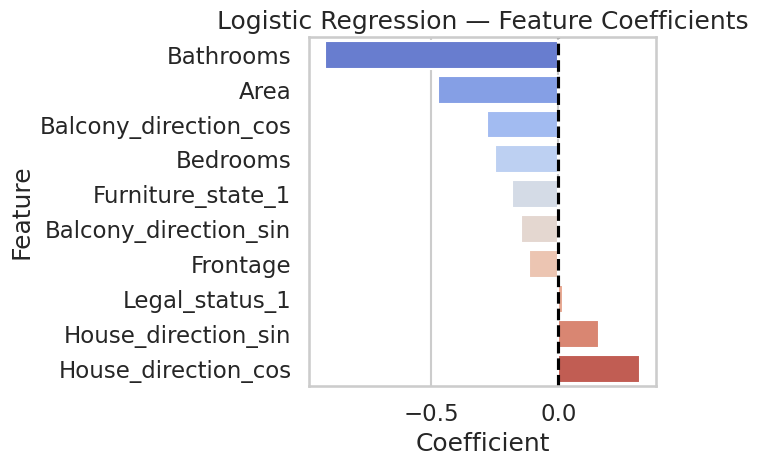

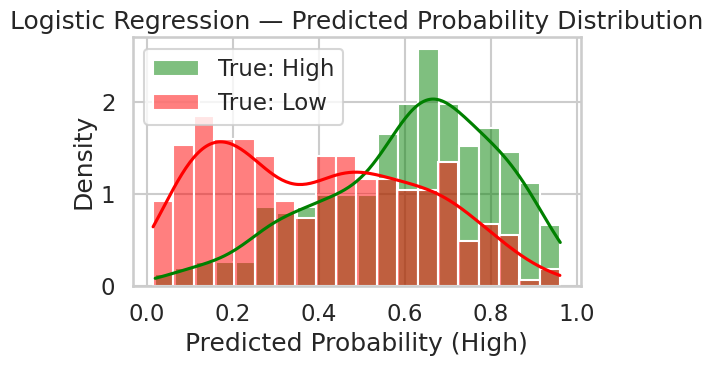

In [308]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay,
    roc_auc_score, precision_recall_curve
)

# === Lấy mô hình Logistic Regression tốt nhất ===
log_model = out["Logistic Regression"]["best"]
clf = log_model.named_steps["clf"]

# === 1️⃣ CONFUSION MATRIX ===
def plot_confusion_matrix_heatmap(model, Xte, yte, title):
    y_pred = model.predict(Xte)
    cm = confusion_matrix(yte, y_pred)
    labels = np.unique(yte)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.title(f"{title} — Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


# === 2️⃣ ROC CURVE + AUC ===
def plot_roc(model, Xte, yte, title):
    y_proba = model.predict_proba(Xte)[:, 1]
    y_true_bin = (yte == yte.cat.categories[1]).astype(int)
    auc = roc_auc_score(y_true_bin, y_proba)

    RocCurveDisplay.from_predictions(y_true_bin, y_proba)
    plt.title(f"{title} — ROC Curve (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.tight_layout()
    plt.show()


# === 3️⃣ PRECISION–RECALL CURVE ===
def plot_precision_recall(model, Xte, yte, title):
    y_proba = model.predict_proba(Xte)[:, 1]
    y_true_bin = (yte == yte.cat.categories[1]).astype(int)

    PrecisionRecallDisplay.from_predictions(y_true_bin, y_proba)
    plt.title(f"{title} — Precision–Recall Curve")
    plt.tight_layout()
    plt.show()


# === 4️⃣ COEFFICIENT PLOT ===
def plot_logistic_coefficients(model, feature_names, title):
    coefs = model.coef_.ravel()
    df = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": coefs
    }).sort_values("Coefficient", ascending=True)

    plt.figure(figsize=(7, 5))
    sns.barplot(data=df, x="Coefficient", y="Feature", palette="coolwarm")
    plt.title(f"{title} — Feature Coefficients")
    plt.axvline(0, color='black', linestyle='--')
    plt.tight_layout()
    plt.show()


# === 5️⃣ HISTOGRAM XÁC SUẤT DỰ ĐOÁN ===
def plot_prediction_histogram(model, Xte, yte, title):
    y_proba = model.predict_proba(Xte)[:, 1]
    y_true_bin = (yte == yte.cat.categories[1]).astype(int)

    plt.figure(figsize=(6, 4))
    sns.histplot(y_proba[y_true_bin == 1], color='green', label='True: High', kde=True, stat="density", bins=20)
    sns.histplot(y_proba[y_true_bin == 0], color='red', label='True: Low', kde=True, stat="density", bins=20)
    plt.title(f"{title} — Predicted Probability Distribution")
    plt.xlabel("Predicted Probability (High)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()


# === 6️⃣ GỌI HÀM VẼ ===
title = "Logistic Regression"
print(f"\n🔹 Biểu đồ phân tích mô hình: {title}")

plot_confusion_matrix_heatmap(log_model, X_test, y_test_cls, title)
plot_roc(log_model, X_test, y_test_cls, title)
plot_precision_recall(log_model, X_test, y_test_cls, title)
plot_logistic_coefficients(clf, X_train.columns, title)
plot_prediction_histogram(log_model, X_test, y_test_cls, title)




## VISUALIZATION FOR DECISION TREE

In [309]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, roc_auc_score
)
from sklearn.tree import plot_tree

# Lấy mô hình Decision Tree tốt nhất từ dict out
tree_model = out["Decision Tree"]["best"]
clf_tree = tree_model.named_steps["clf"]
title = "Decision Tree"


**Confusion Matrix**

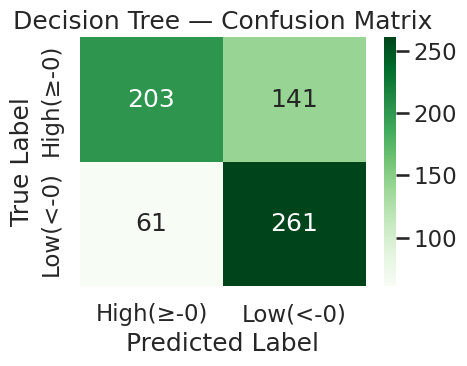

In [310]:
def plot_confusion_matrix_heatmap(model, Xte, yte, title):
    y_pred = model.predict(Xte)
    cm = confusion_matrix(yte, y_pred)
    labels = np.unique(yte)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
                xticklabels=labels, yticklabels=labels)
    plt.title(f"{title} — Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix_heatmap(tree_model, X_test, y_test_cls, title)


**ROC Curve/Precision-Recall**


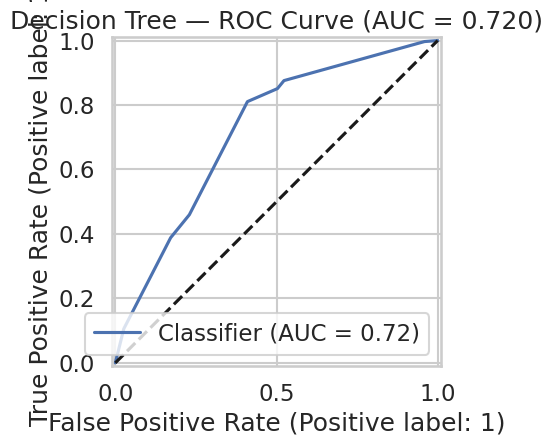

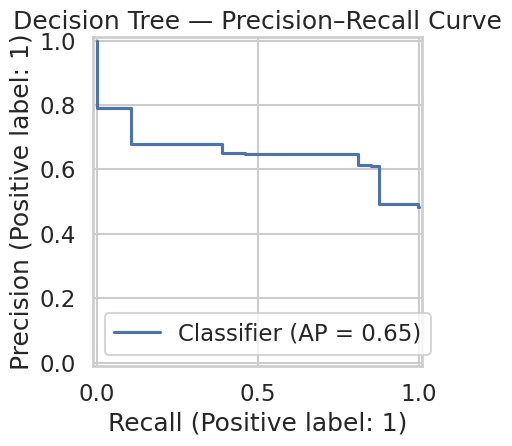

In [311]:
def plot_roc_pr_curves(model, Xte, yte, title):
    y_proba = model.predict_proba(Xte)[:, 1]
    y_true_bin = (yte == yte.cat.categories[1]).astype(int)
    auc = roc_auc_score(y_true_bin, y_proba)

    # ROC Curve
    RocCurveDisplay.from_predictions(y_true_bin, y_proba)
    plt.title(f"{title} — ROC Curve (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.tight_layout()
    plt.show()

    # Precision–Recall Curve
    PrecisionRecallDisplay.from_predictions(y_true_bin, y_proba)
    plt.title(f"{title} — Precision–Recall Curve")
    plt.tight_layout()
    plt.show()

plot_roc_pr_curves(tree_model, X_test, y_test_cls, title)


**Tree Structure**

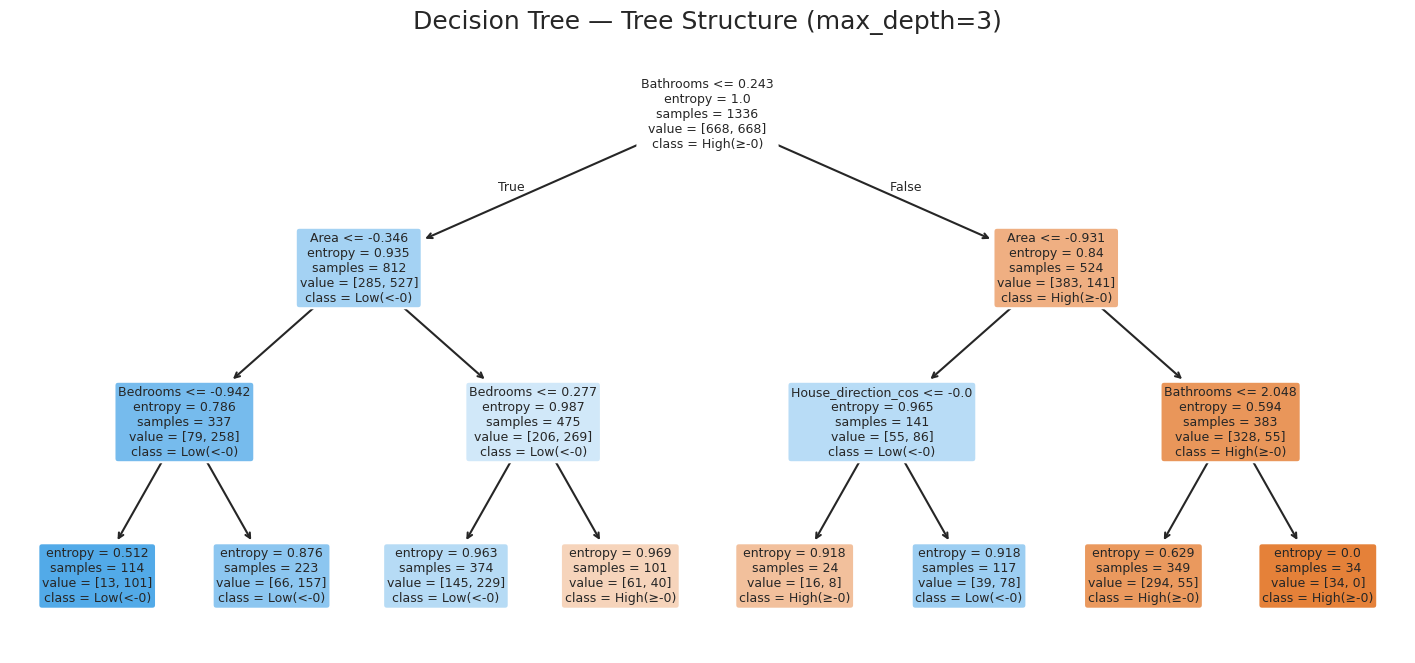

In [312]:
def plot_decision_tree_structure(model, feature_names, title, max_depth=3):
    plt.figure(figsize=(18, 8))
    plot_tree(
        model,
        feature_names=feature_names,
        class_names=[str(c) for c in model.classes_],
        filled=True, rounded=True,
        fontsize=9, max_depth=max_depth
    )
    plt.title(f"{title} — Tree Structure (max_depth={max_depth})")
    plt.show()

plot_decision_tree_structure(clf_tree, X_train.columns, title, max_depth=3)


## VISUALIZATION FOR RANDOM FOREST

**Confusion Matrix**

<Figure size 400x400 with 0 Axes>

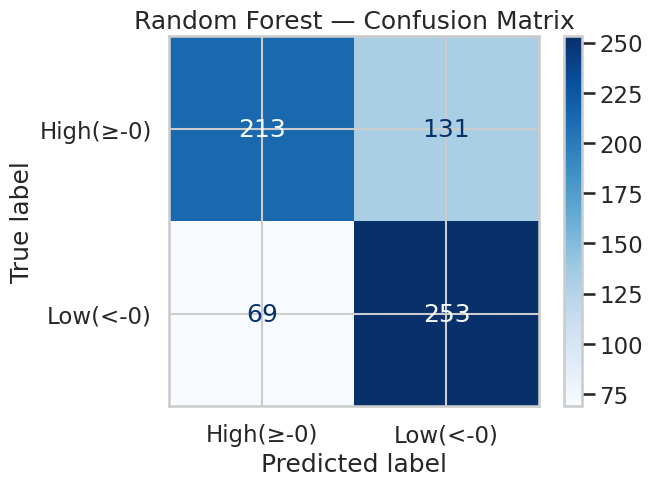

In [313]:
#  Bộ biểu đồ đánh giá mô hình Random Forest
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.inspection import PartialDependenceDisplay
import shap
import numpy as np

rf_model = out["Random Forest"]["best"]

# Confusion Matrix 
plt.figure(figsize=(4, 4))
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test_cls, cmap="Blues", values_format="d")
plt.title("Random Forest — Confusion Matrix")
plt.show()

**ROC Curve/Precision–Recall Curve**

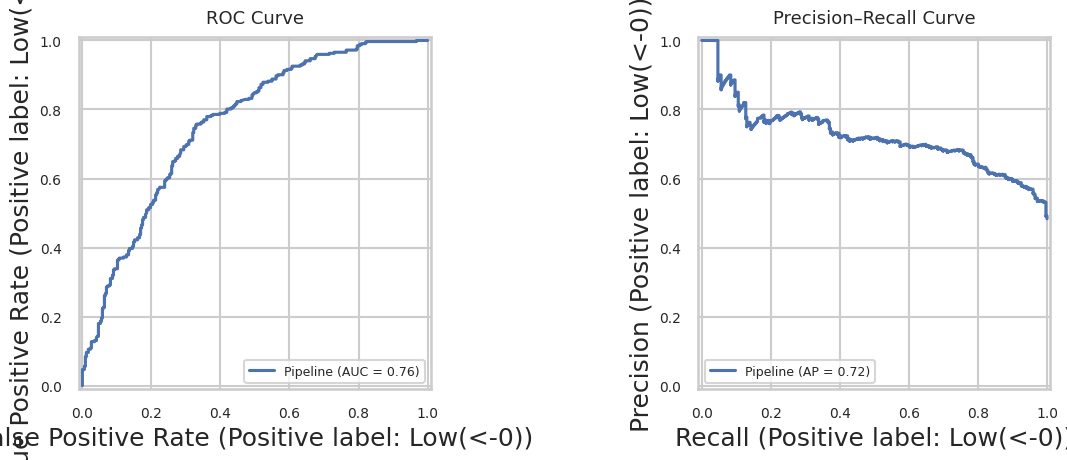

In [314]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5), dpi=100)

RocCurveDisplay.from_estimator(rf_model, X_test, y_test_cls, ax=axes[0])
axes[0].set_title("ROC Curve", fontsize=13, pad=10)
axes[0].tick_params(labelsize=10)
axes[0].legend(loc='lower right', fontsize=9)

PrecisionRecallDisplay.from_estimator(rf_model, X_test, y_test_cls, ax=axes[1])
axes[1].set_title("Precision–Recall Curve", fontsize=13, pad=10)
axes[1].tick_params(labelsize=10)
axes[1].legend(loc='lower left', fontsize=9)

plt.tight_layout()
plt.subplots_adjust(wspace=0.3, top=0.88)  
plt.show()


**Feature Importance**

/tmp/ipykernel_5573/749850736.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[v for _, v in feat_imp[:10]], y=[f for f, _ in feat_imp[:10]], palette="crest")


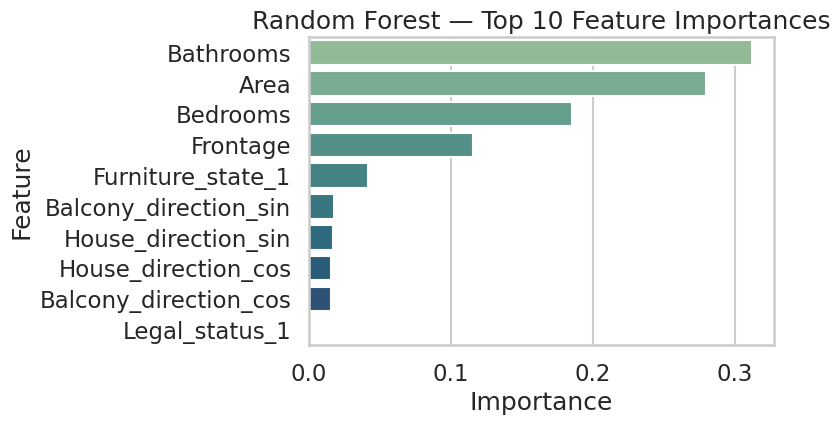

In [315]:
importances = rf_model.named_steps['clf'].feature_importances_

feat_imp = sorted(zip(X_test.columns, importances), key=lambda x: x[1], reverse=True)
plt.figure(figsize=(6, 4))
sns.barplot(x=[v for _, v in feat_imp[:10]], y=[f for f, _ in feat_imp[:10]], palette="crest")
plt.title("Random Forest — Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

**Partial Dependence Plot (PDP)**

<Figure size 800x300 with 0 Axes>

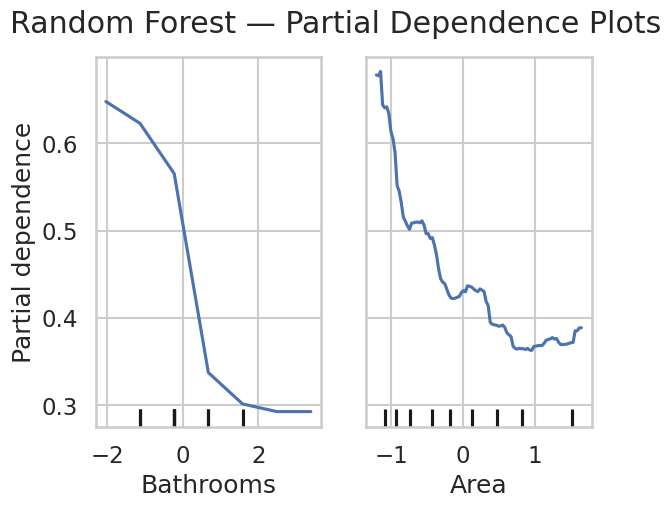

In [316]:
plt.figure(figsize=(8, 3))
PartialDependenceDisplay.from_estimator(
    rf_model, X_test, features=[feat_imp[0][0], feat_imp[1][0]], kind="average"
)
plt.suptitle("Random Forest — Partial Dependence Plots")
plt.show()

**Prediction Probability Histogram**

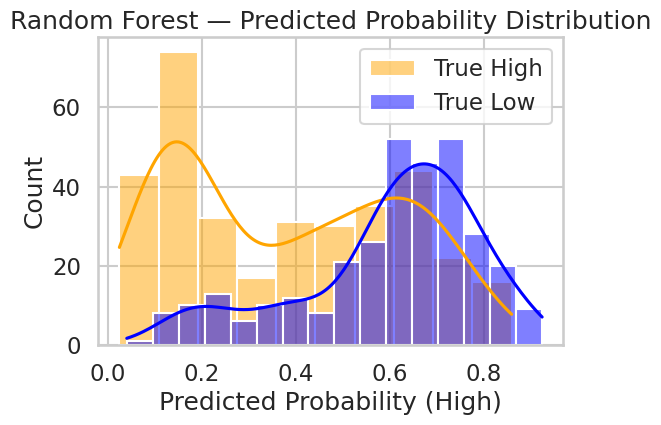

In [317]:
proba = rf_model.predict_proba(X_test)[:, 1]
plt.figure(figsize=(6, 4))
sns.histplot(proba[y_test_cls == "High(≥-0)"], color="orange", label="True High", kde=True)
sns.histplot(proba[y_test_cls == "Low(<-0)"], color="blue", label="True Low", kde=True)
plt.legend()
plt.title("Random Forest — Predicted Probability Distribution")
plt.xlabel("Predicted Probability (High)")
plt.show()

# Dự báo giá nhà

In [318]:
rf_best   = out['Random Forest']['best']
tree_best = out['Decision Tree']['best']
log_best  = out['Logistic Regression']['best']

In [319]:
# ===== DỰ BÁO =====
best = rf_best  

# Dự báo nhãn (High/Low) và xác suất thuộc nhóm High
y_pred_label = best.predict(X_test)
y_pred_prob  = best.predict_proba(X_test)[:, 1]

# Gộp kết quả vào bảng test
pred_table = vietnam_housing_test_clean.copy()
pred_table['Pred_Prob_High'] = y_pred_prob
pred_table['Pred_Label'] = y_pred_label

# ===== TÍNH THEO MEDIAN PRICE =====
import numpy as np

thr = float(np.median(y_train_cont))  # median của cột Price trong tập train
print(f"Median của Price (ngưỡng phân loại): {thr:.2f} ")

# Đếm số căn dự báo High / Low
n_high = (pred_table['Pred_Label'].astype(str).str.contains("High")).sum()
n_low  = (pred_table['Pred_Label'].astype(str).str.contains("Low")).sum()
total  = len(pred_table)

print(f"Dự báo: {n_high}/{total} căn có giá ≥ {thr:.2f} ; {n_low}/{total} căn có giá < {thr:.2f} ")

# Xem vài dòng đầu tiên
pred_table.head()


Median của Price (ngưỡng phân loại): -0.14 
Dự báo: 282/666 căn có giá ≥ -0.14 ; 384/666 căn có giá < -0.14 


Address      Area  Frontage  \
1616  Đường Bình Kỳ, Phường Hòa Quý, Ngũ Hành Sơn, Đ...  1.517213  0.801804   
254   Đường Hoàng Sa, Phường Phước Long, Nha Trang, ...  1.439366  0.801804   
1146  Đường Dương Quảng Hàm, Phường 5, Gò Vấp, Hồ Ch... -1.479912 -0.954230   
188   Đường Biên Giang, Phường Biên Giang, Hà Đông, ... -1.129599 -1.288712   
1808  Phố Trần Cung, Phường Nghĩa Tân, Cầu Giấy, Hà Nội -0.312201 -0.591873   

      Access Road House direction Balcony direction  Floors  Bedrooms  \
1616    -0.233798       Tây - Nam         Tây - Nam       2 -0.443915   
254      1.215878      Đông - Bắc        Đông - Bắc       2 -0.443915   
1146    -0.523734       Tây - Bắc         Tây - Bắc       2 -1.680934   
188     -0.813669      Đông - Nam        Đông - Nam       5 -0.443915   
1808    -0.668701       Tây - Nam         Tây - Nam       3  0.793104   

      Bathrooms      Legal status Furniture state     Price  \
1616  -0.229795  Have certificate            Full -1.068516   
254   -1.135378  Have certificate           Basic  1.866571   
1146  -2.040961  Have certificate            Full -1.368958   
188    0.675788  Have certificate           Basic -1.160959   
1808  -0.229795  Have certificate           Basic  0.664803   

      House_direction_sin  House_direction_cos  Balcony_direction_sin  \
1616                  0.0                  1.0                    0.0   
254                   0.0                  1.0                    0.0   
1146                  0.0                  1.0                    0.0   
188                   0.0                  1.0                    0.0   
1808                  0.0                  1.0                    0.0   

      Balcony_direction_cos  Legal_status_1  Furniture_state_1  \
1616                    1.0           False               True   
254                     1.0           False              False   
1146                    1.0           False               True   
188                     1.0           False              False   
1808                    1.0           False              False   

      Pred_Prob_High Pred_Label  
1616        0.386862  High(≥-0)  
254         0.655099   Low(<-0)  
1146        0.912814   Low(<-0)  
188         0.766202   Low(<-0)  
1808        0.601738   Low(<-0)